# Notebook for running the snmachine pipeline on Supernova Photometric Classification Challenge simulated data

This notebook illustrates the use of the `snmachine` supernova classification package by classifying a subset simulated data from the supernova photometric classification challenge (SPCC). 

See Lochner et al. (2016): http://arxiv.org/abs/1603.00882

NOTE: The results here differ slightly from the paper because we're using a much smaller dataset (in the interest of disk space and speed). Additionally, here the feature extraction methods use least squares (which is must faster) whereas in the paper we used nested sampling for more accurate fits.

<img src="pipeline.png" width=600>

This image illustrates the how the pipeline works. As the user, you can choose what feature extraction method you want to use. Here we have three (four, technically, since there are two parametric models) but it's straighforward to write a new feature extraction method. Once features have been extracted, they can be run through one of several machine learning algorithms and again, it's easy to write your own algorithm into the pipeline. There's a convenience function in `snclassifier` to run a feature set through multiple algorithms and plot the result. The rest of this notebook goes through applying each of the feature extraction methods to a set of simulations and running all feature sets through different classification algorithms.

In [1]:
!pip install ../../snmachine/

Processing /home/calves/plasticc/snmachine
  Created wheel for snmachine: filename=snmachine-1.6.1.dev159+g44c9a89.d20210709-py3-none-any.whl size=34595773 sha256=bd1b2004e303be81067c0f833037b48c53d0f49b14ed71a0bf2d21e95aa3bd1f
  Stored in directory: /tmp/pip-ephem-wheel-cache-yil7tydm/wheels/13/7b/ca/00f02bcadf757a875da9908d15077f22cbe44117f06f581e95
Successfully built snmachine
  Attempting uninstall: snmachine
    Found existing installation: snmachine 1.6.1.dev158+gf1cf768.d20210709
    Uninstalling snmachine-1.6.1.dev158+gf1cf768.d20210709:
      Successfully uninstalled snmachine-1.6.1.dev158+gf1cf768.d20210709


In [2]:
import os

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
from astropy.table import Table
from snmachine import example_data, sndata, snfeatures, tsne_plot, snclassifier
from utils.plasticc_pipeline import create_folder_structure, get_directories

No module named 'pymultinest'

                PyMultinest not found. If you would like to use, please install
                Mulitnest with 'sh install/multinest_install.sh; source
                install/setup.sh'
                


In [5]:
%config Completer.use_jedi = False  # enable autocomplete

#### Aestetic settings

In [6]:
%matplotlib nbagg

sns.set(font_scale=1., style="ticks")

## Set up output structure

We make lots of output files so it makes sense to put them in one place. This is the recommended output file structure.

We start by **naming** our analysis.

In [7]:
dataset_name = 'spcc'
analysis_name = os.path.join(f'output_{dataset_name}_no_z')

Then, we **write** in `folder_path` the path where to save the folder.

Note that `MultiNest` uses a hardcoded character limit for the output file names (we believe it is 100 characters). Thus, avoid making this file path to lengthy if using nested sampling otherwise the multinest output file names will be truncated.

In [8]:
folder_path = '.'

Create the folder structure.

In [ ]:
create_folder_structure(folder_path, analysis_name)

See the folder structure. We save:
* the extracted features in `directories['features_directory']`
* the classification probabilities and ROC curves in `directories['classifications_directory']`
* the any intermediate files (such as multinest chains or GP fits) in `directories['intermediate_files_directory']`

In [9]:
directories = get_directories(folder_path, analysis_name) 
directories

{'analysis_directory': './output_spcc_no_z',
 'features_directory': './output_spcc_no_z/wavelet_features',
 'classifications_directory': './output_spcc_no_z/classifications',
 'intermediate_files_directory': './output_spcc_no_z/intermediate_files',
 'plots_directory': './output_spcc_no_z/plots'}

In [10]:
path_saved_features = directories['features_directory']
path_saved_interm = directories['intermediate_files_directory']
path_saved_classifier = directories['classifications_directory']

## Initialise dataset object

Load a subset of the SPCC DES simulated data (http://arxiv.org/abs/1008.1024). For that, we **write** the path where the data is. Alternatively, we can automatically untar the data.

In [11]:
data_path = os.path.join(example_data, 'SPCC_SUBSET', '')

In [12]:
if not os.path.exists(data_path):  # automatically untar the data
    subprocess.call(['tar', '-zxvf', 'SPCC_SUBSET.tar.gz'])

In [13]:
dataset = sndata.Dataset(data_path)

Reading data...
2000 objects read into memory.


For now we restrict ourselves to three supernova types: Ia (1), II (2) and Ibc (3).

In [14]:
types = dataset.get_types()
types['Type'][np.floor(types['Type']/10)==2] = 2
types['Type'][np.floor(types['Type']/10)==3] = 3

Now we can plot all the data and cycle through it (left and right arrows on your keyboard).

In [ ]:
dataset.plot_all()

Each light curve is represented in the Dataset object as an astropy table, compatible with `sncosmo`:

In [ ]:
dataset.data[dataset.object_names[0]]

## Extract features for the data

The next step is to extract useful features from the data. This can often take a long time, depending on the feature extraction method, so it's a good idea to save these to file.

In [15]:
read_from_file = False  # use this flag to quickly rerun from saved features
run_name = os.path.join(path_saved_features, f'{dataset_name}_all')

### 1. SALT2 Template features

In [16]:
# This is a Features object, not yet the extracted features
salt2_features_instance = snfeatures.TemplateFeatures(sampler='leastsq')

This performs the actual feature extraction. All feature extraction methods are parallelised with multiprocessing, just set `nprocesses`>1 for parallelisation.

In [ ]:
if read_from_file:
    print('Reading from file...')
    salt2_features = Table.read(f'{run_name}_templates.dat', 
                                format='ascii')
else:
    print('Feature extraction...')
    salt2_features = salt2_features_instance.extract_features(
        dataset, use_redshift=True, number_processes=4, 
        chain_directory=path_saved_interm)
    salt2_features.write(f'{run_name}_templates.dat', format='ascii')

Then, we take the fitted parameters and generate the model light curve for plotting purposes.

In [24]:
dataset.set_model(salt2_features_instance.fit_sn, salt2_features)

Fitting transient models...
Models fitted.


Unfortunately, sometimes the fitting methods return NaN for some parameters for these models.

In [34]:
for c in salt2_features.colnames[1:]:
    print(np.sum(np.isnan(salt2_features[c])))
    salt2_features[c][np.isnan(salt2_features[c])] = 0

0
6
6
6
6


Now we can see how well the SALT2 model fits our light curves.

<IPython.core.display.Javascript object>


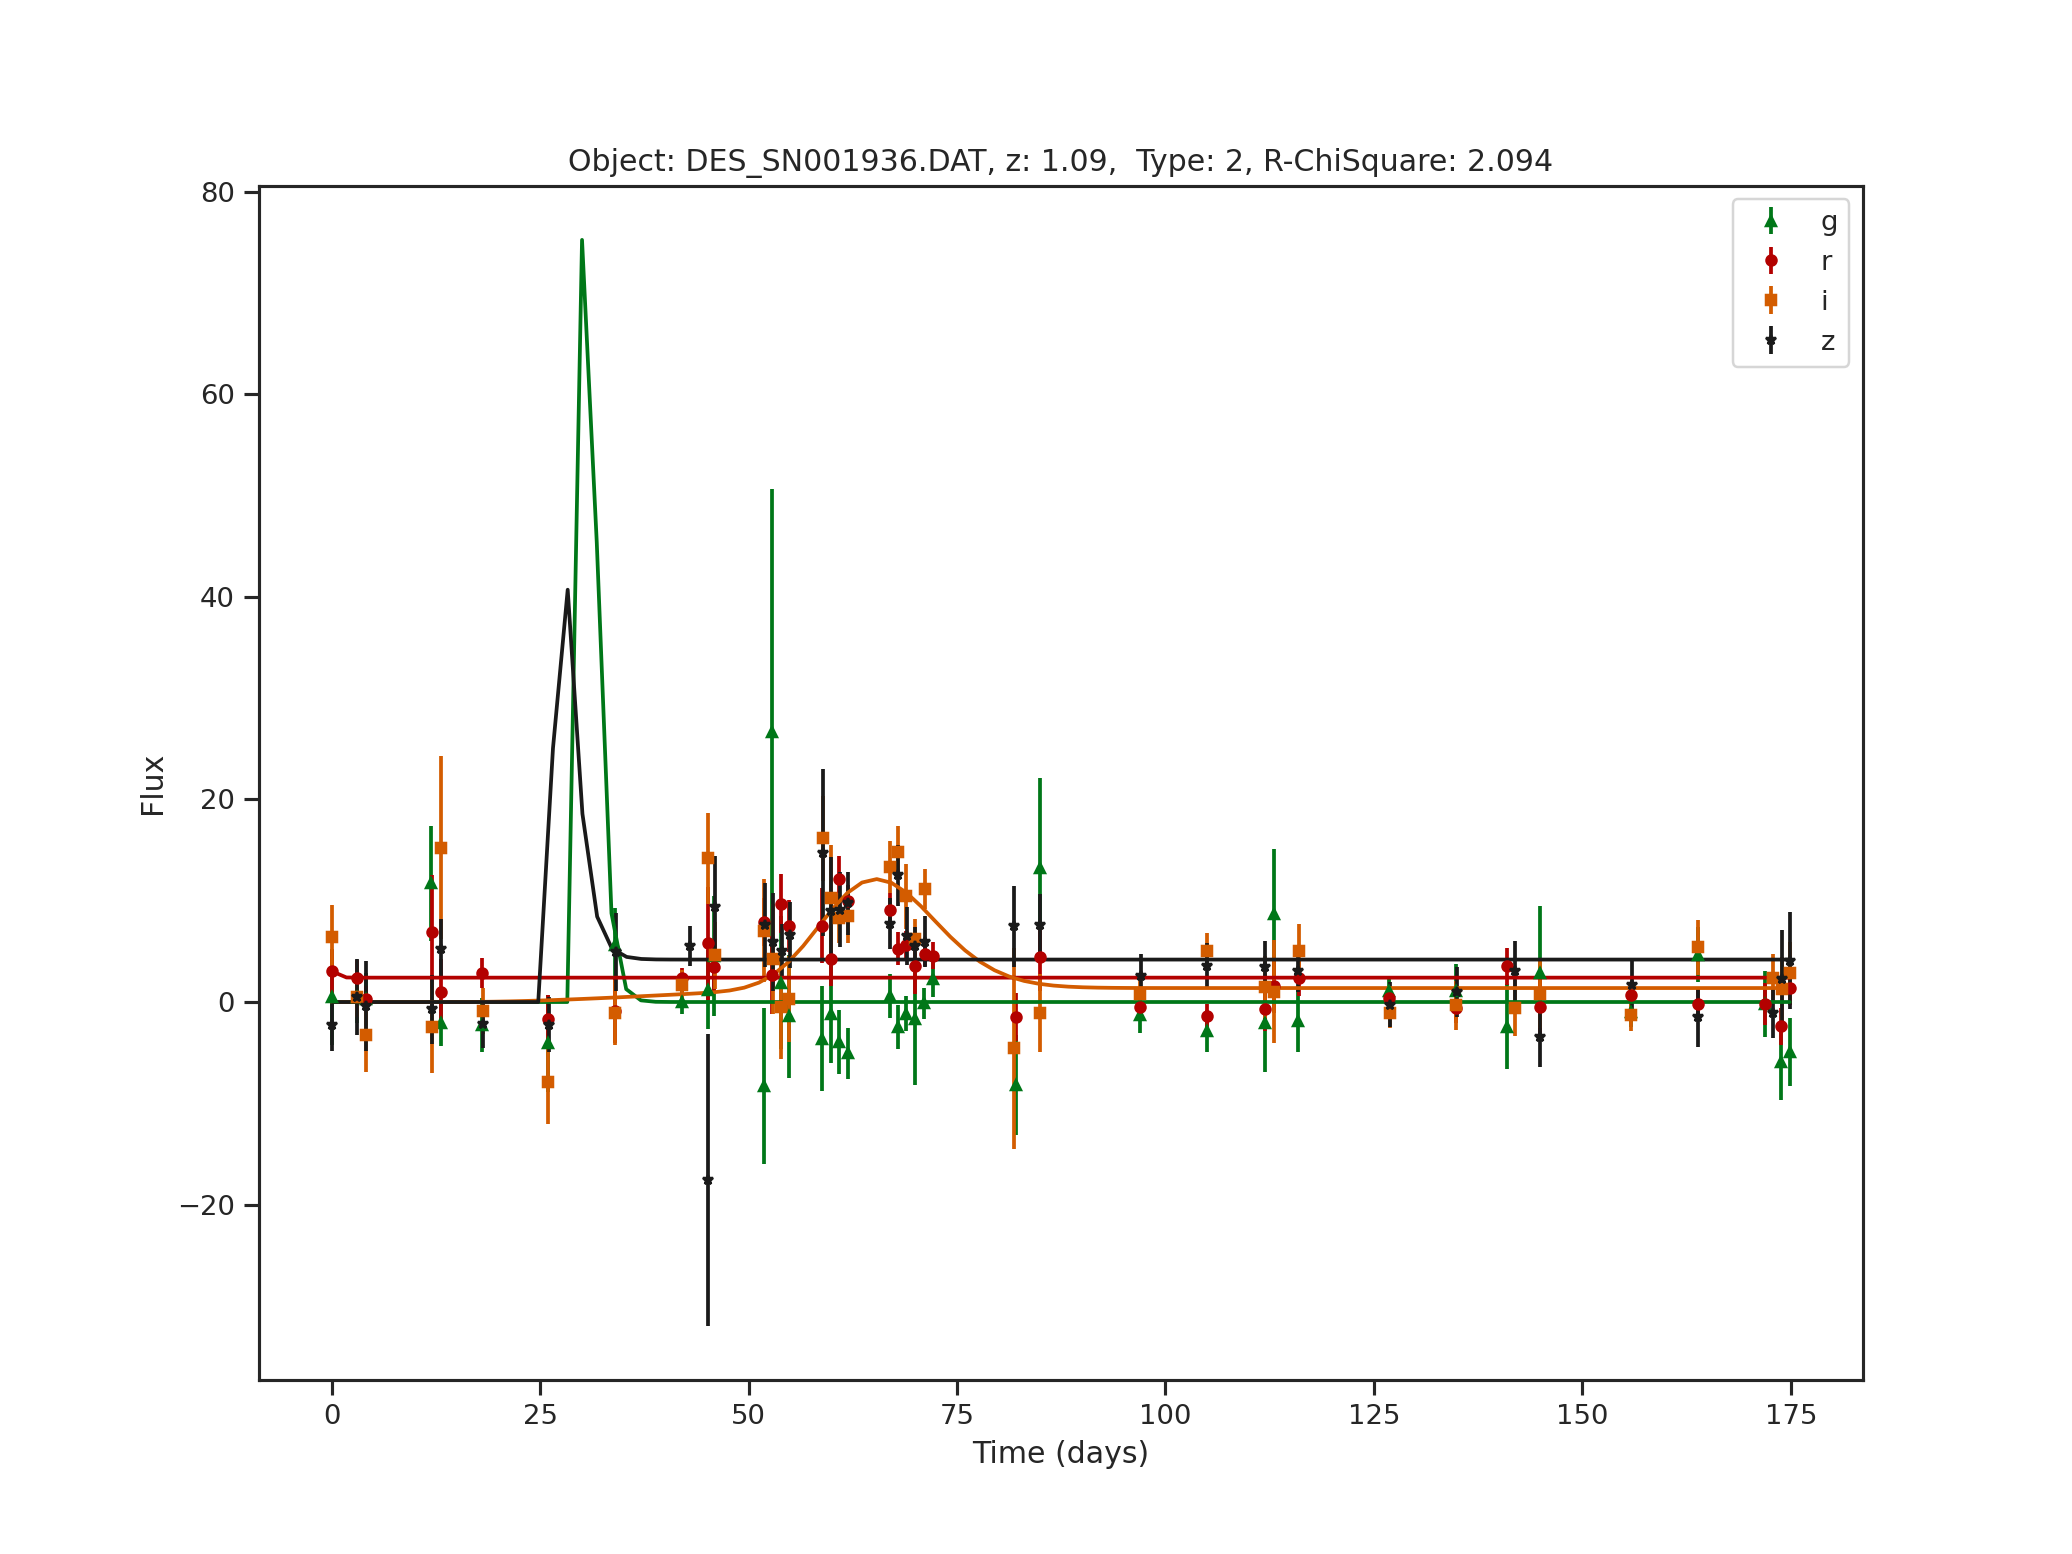

In [35]:
dataset.plot_all()

t-SNE plots: 
These are useful visualisation plots which embed high dimensional features into a lower dimensional space to indicate how well the features separate between classes (see https://lvdmaaten.github.io/tsne/).

<IPython.core.display.Javascript object>


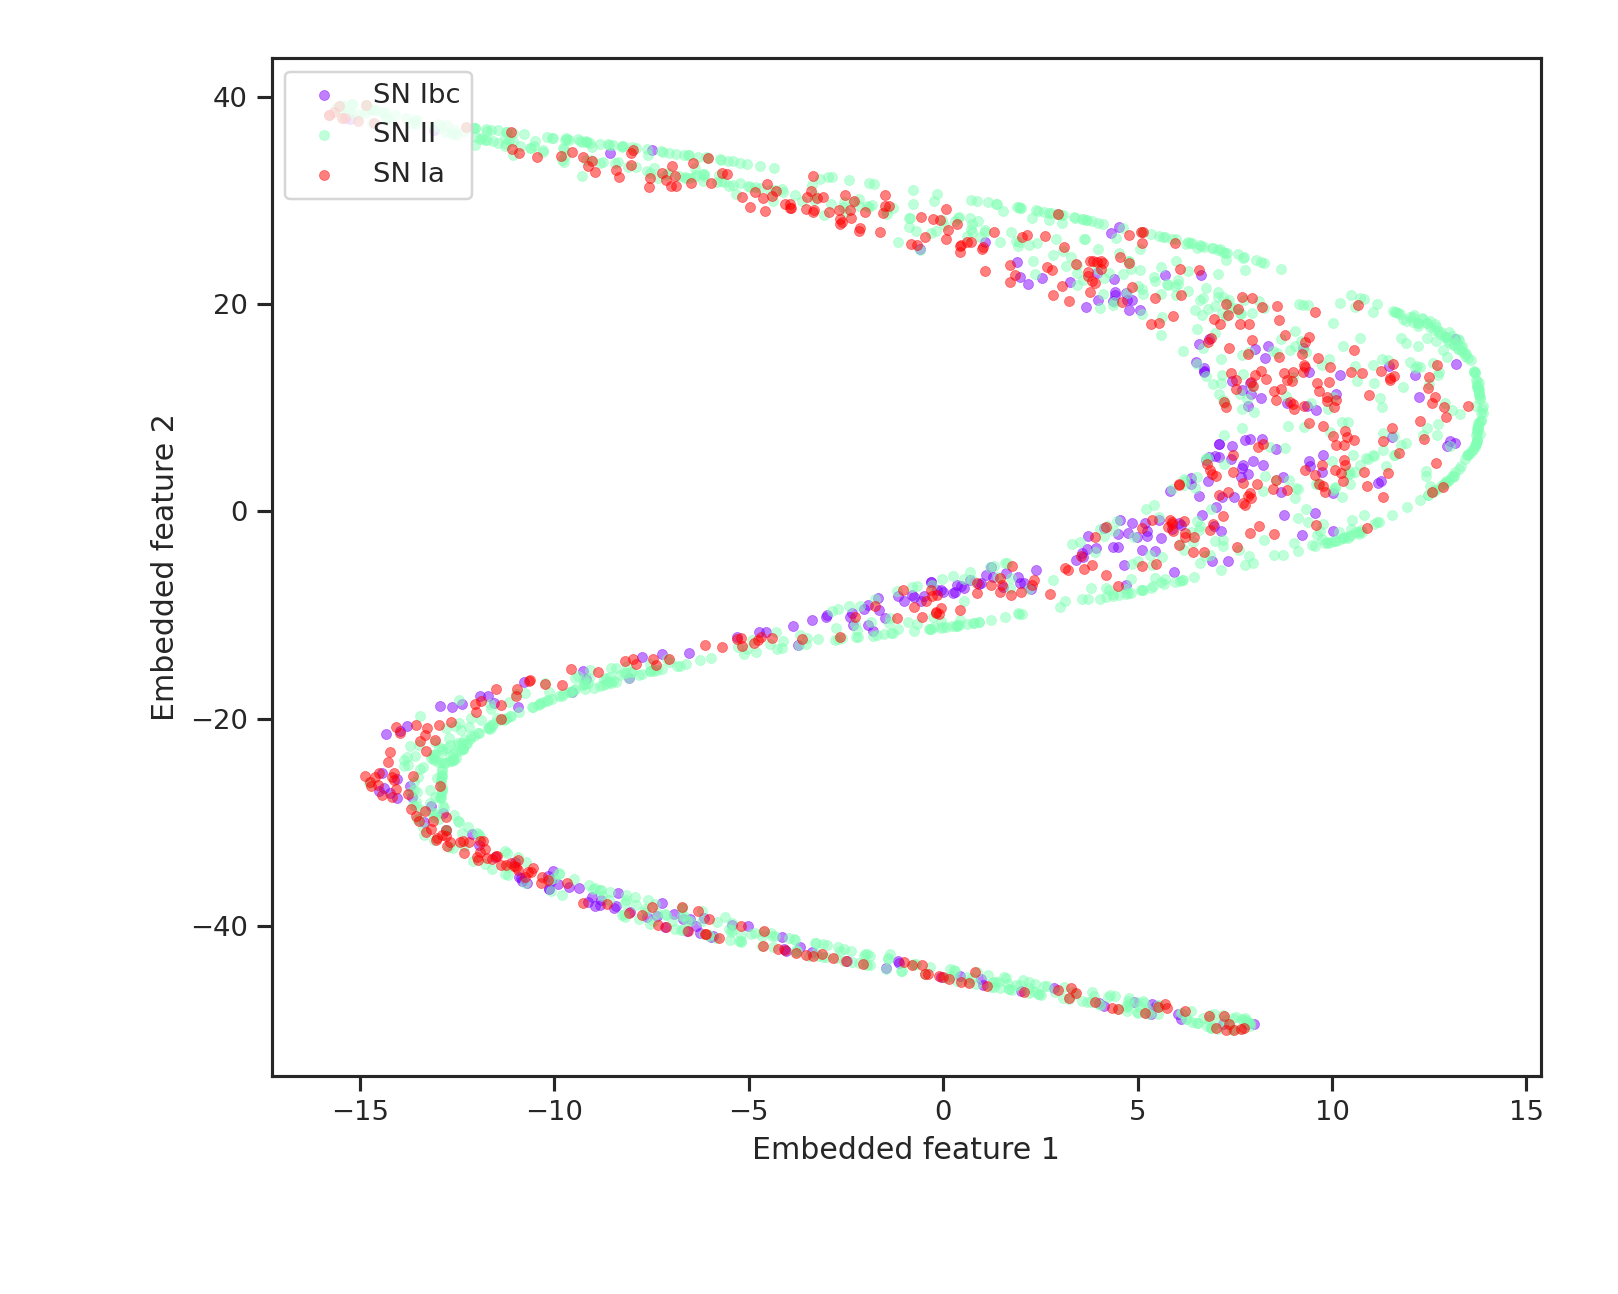

In [36]:
plt.figure(figsize=(5,4))
tsne_plot.plot(salt2_features, types['Type'], type_dict={1:'SN Ia', 2:'SN II', 3: 'SN Ibc'})

### 2.1 Parametric fits - model 1 (Newling et al.)

In [27]:
model1_features_instance = snfeatures.ParametricFeatures(
    'newling', sampler='leastsq')

In [28]:
%%capture --no-stdout
if read_from_file:
    model1_features = Table.read(f'{run_name}_newling.dat', 
                               format='ascii')
    better_name = mod1_features['Object'].astype(str)
    model1_features.replace_column('Object', better_name)
else:
    model1_features = model1_features_instance.extract_features(
        dataset, number_processes=4, chain_directory=path_saved_interm)
    model1_features.write(f'{run_name}_newling.dat', format='ascii')

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
2000 objects fitted
Time taken is 29.20 minutes


Unfortunately, sometimes the fitting methods return NaN for some parameters for these models.

In [29]:
for c in model1_features.colnames[1:]:
    print(np.sum(np.isnan(model1_features[c])))
    model1_features[c][np.isnan(model1_features[c])] = 0

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


Finally, we take the features and generate the model light curve for plotting purposes.

In [30]:
dataset.set_model(model1_features_instance.fit_sn, model1_features)

Fitting transient models...
Models fitted.


Now we can see how well the SALT2 model fits our light curves.

<IPython.core.display.Javascript object>


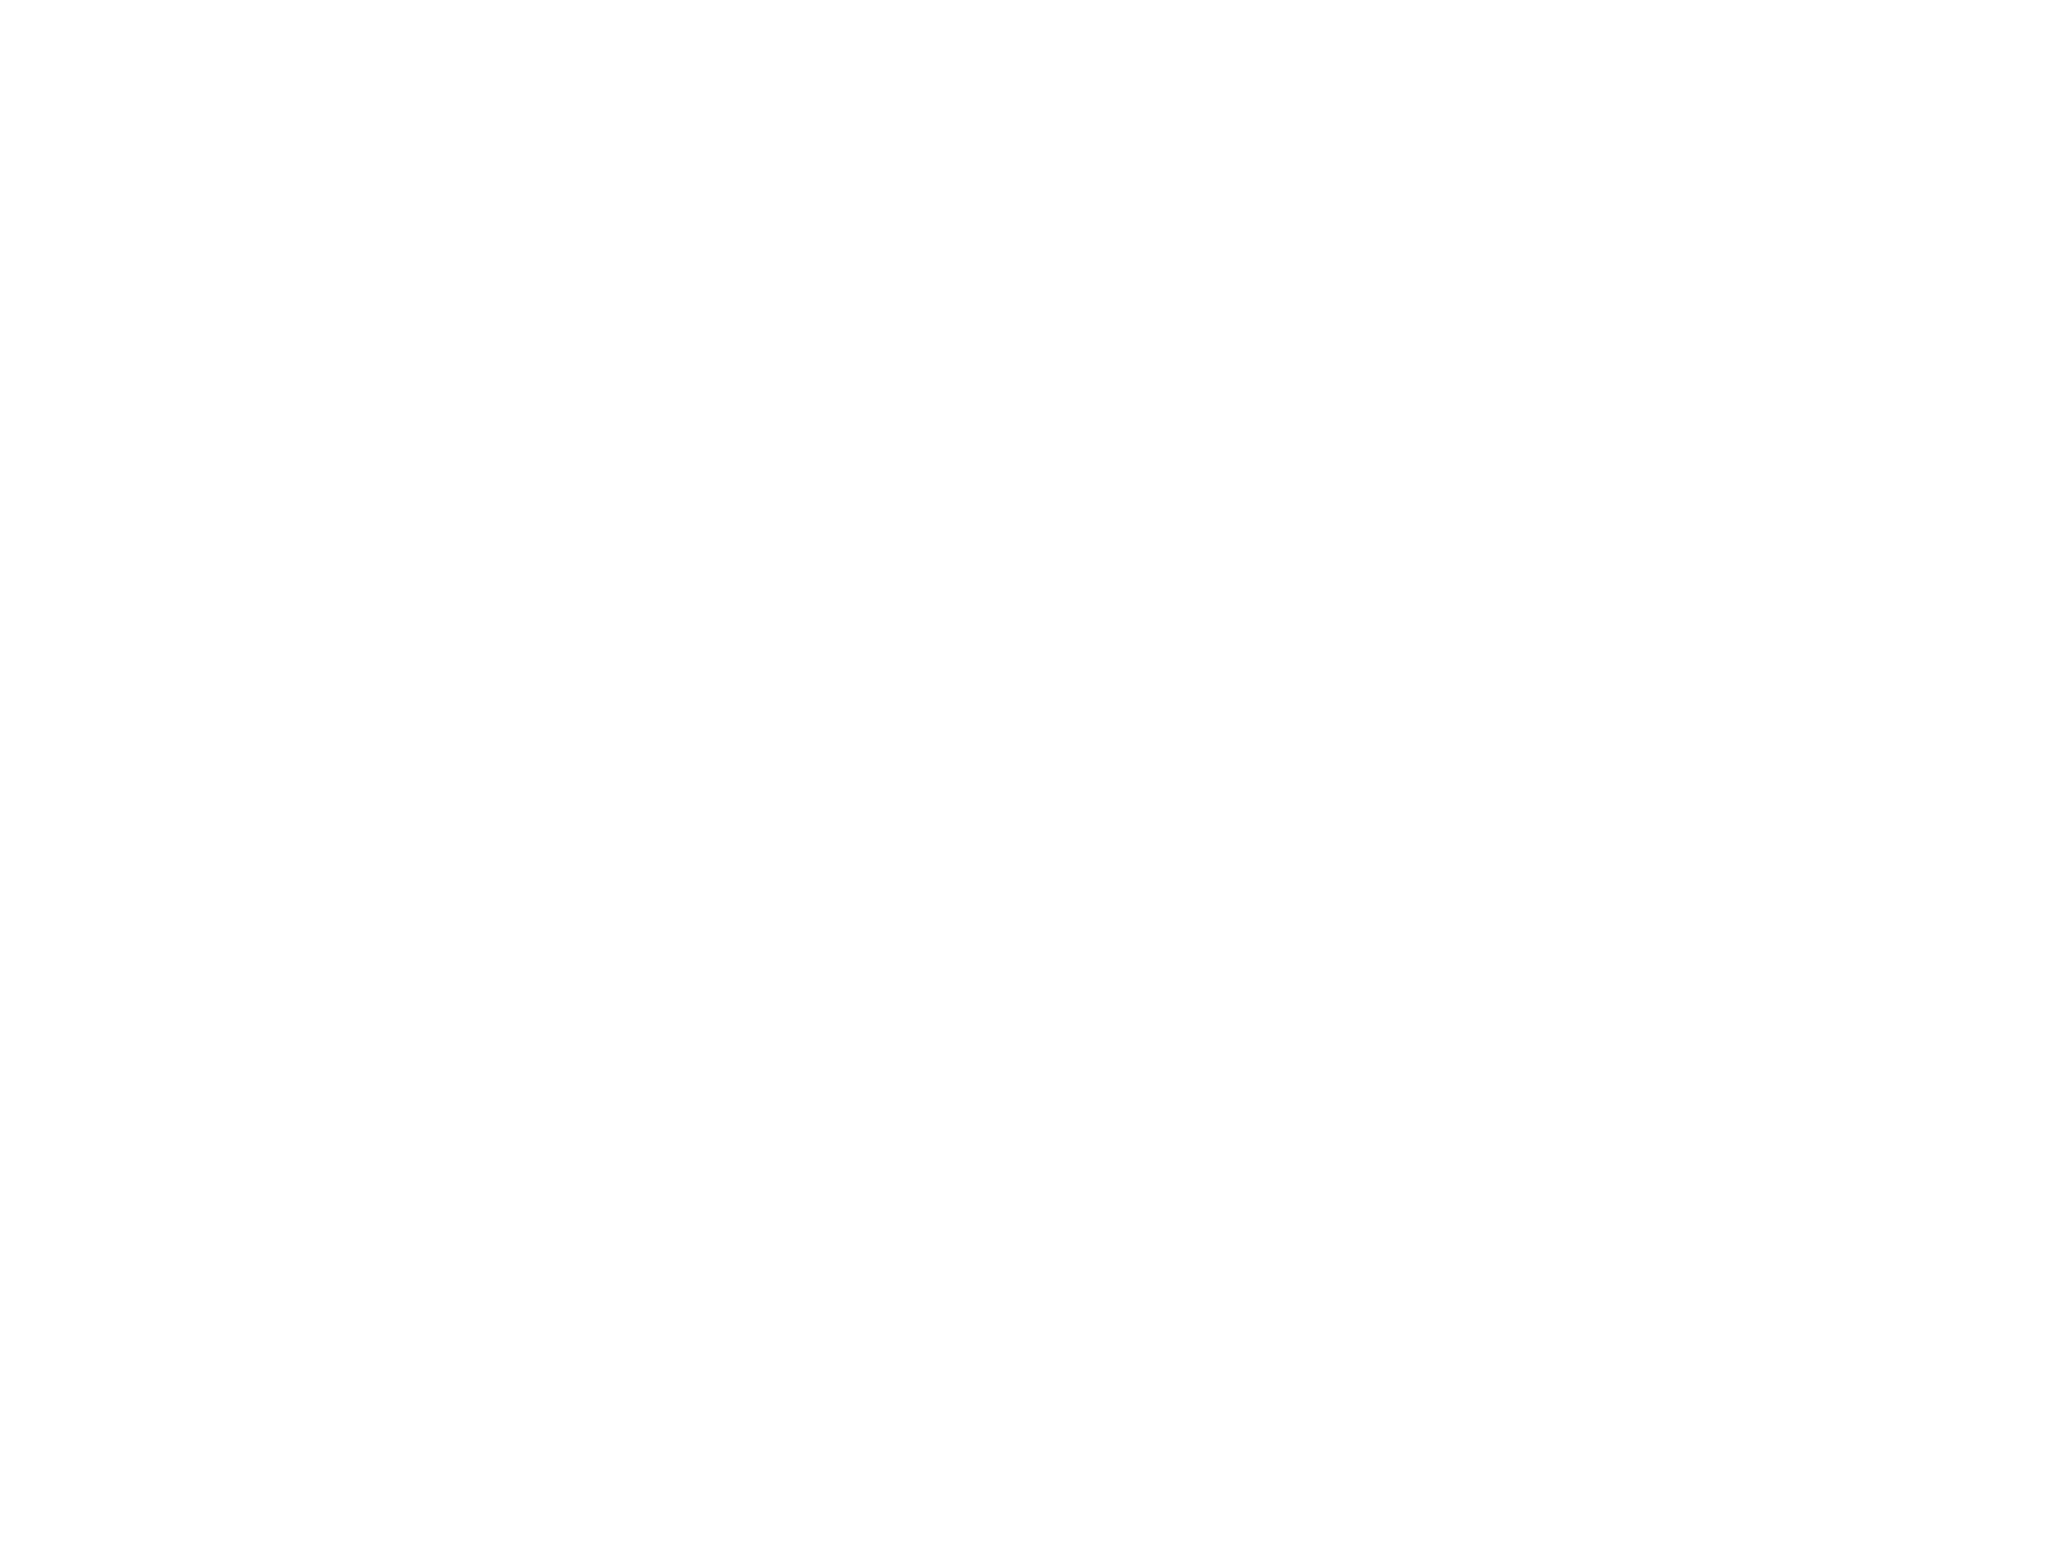

In [31]:
dataset.plot_all()

We also make a t-SNE plot.

<IPython.core.display.Javascript object>


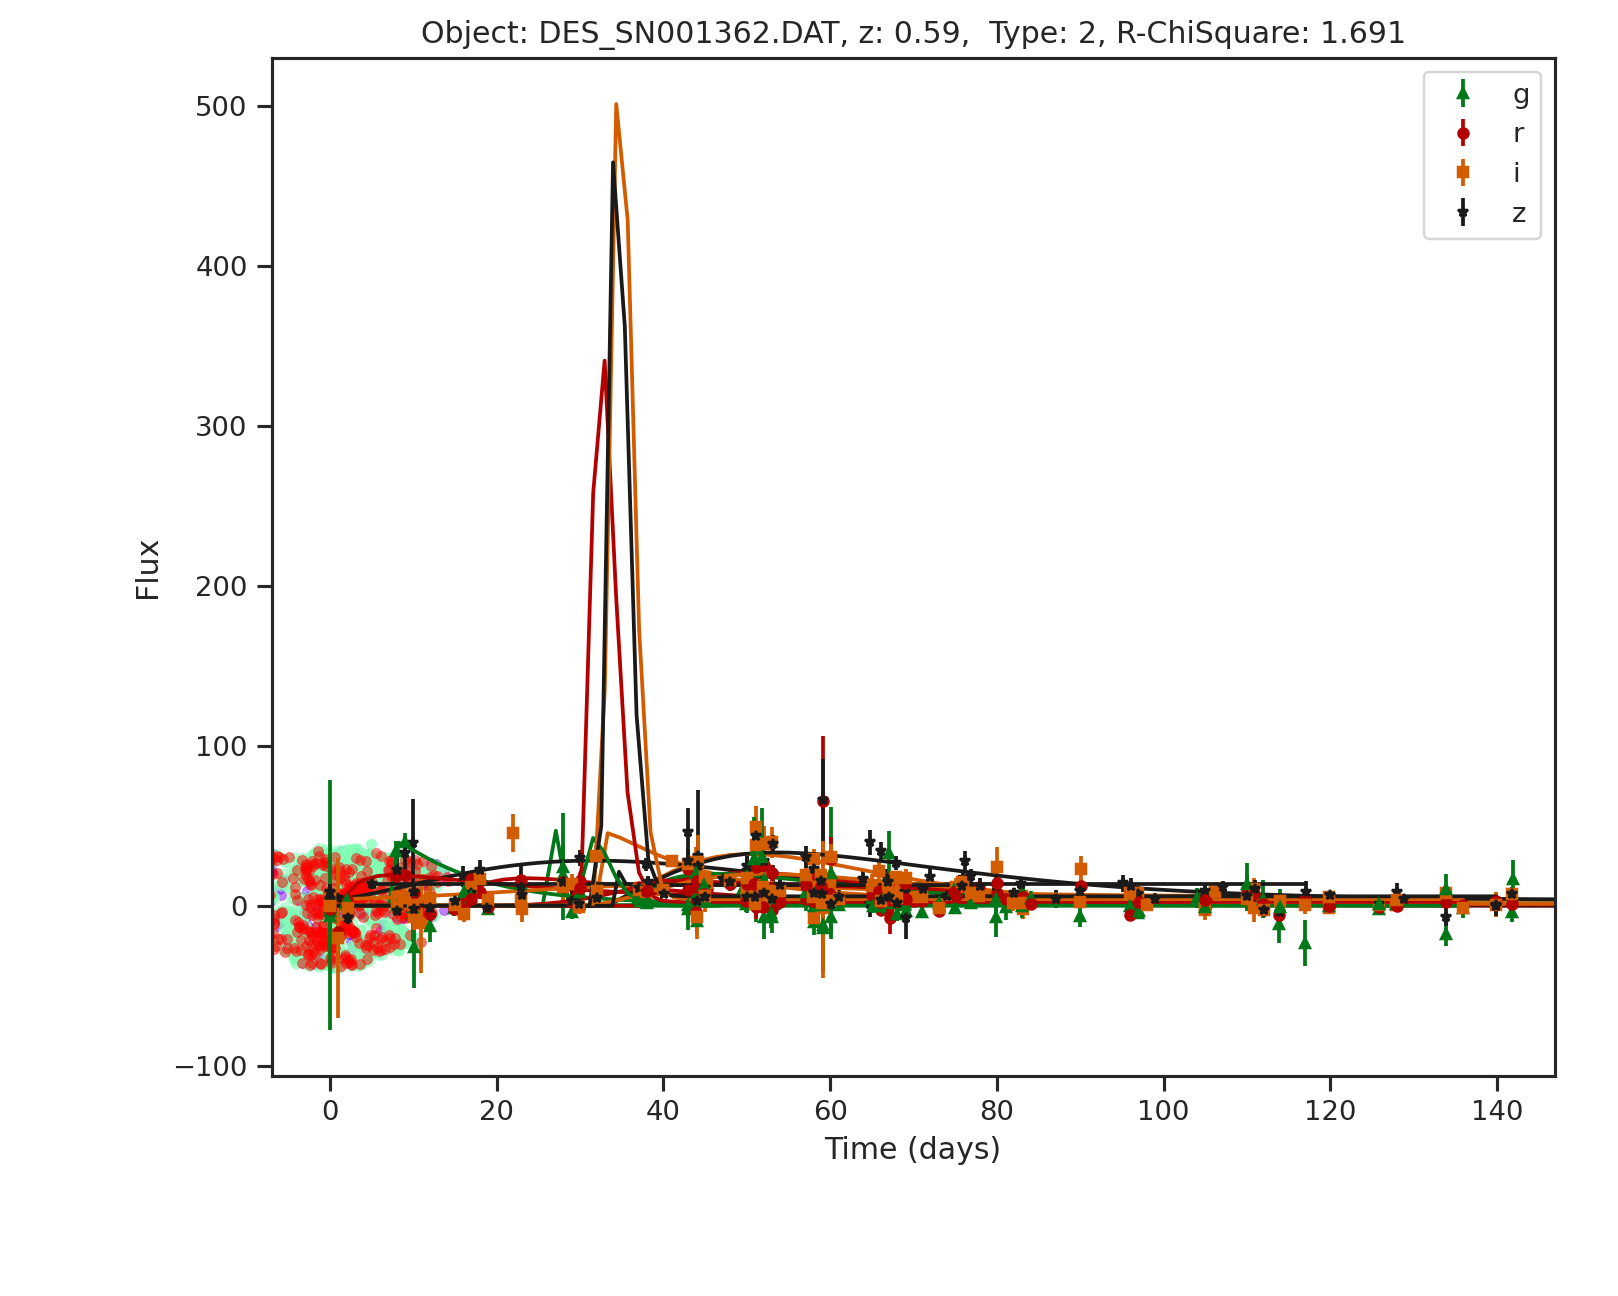

In [32]:
plt.figure(figsize=(5,4))
tsne_plot.plot(model1_features, types['Type'], type_dict={1:'SN Ia', 2:'SN II', 3: 'SN Ibc'})

### 2.2 Parametric fits - model 2 (Karpenka et al.)

In [37]:
model2_features_instance = snfeatures.ParametricFeatures(
    'karpenka', sampler='leastsq')

In [38]:
%%capture --no-stdout
if read_from_file:
    model2_features = Table.read(f'{run_name}_karpenka.dat', format='ascii')
    better_name = model2_features['Object'].astype(str)
    model2_features.replace_column('Object', better_name)
else:
    model2_features = model2_features_instance.extract_features(
        dataset, number_processes=4, chain_directory=path_saved_interm)
    model2_features.write(f'{run_name}_karpenka.dat', format='ascii')

2000 objects fitted
Time taken is 18.34 minutes


Unfortunately, sometimes the fitting methods return NaN for some parameters for these models.

In [39]:
for c in model2_features.colnames[1:]:
    print(np.sum(np.isnan(model2_features[c])))
    model2_features[c][np.isnan(model2_features[c])] = 0

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


Finally, we take the features and generate the model light curve for plotting purposes.

In [40]:
dataset.set_model(model2_features_instance.fit_sn, model2_features)

Fitting transient models...
Models fitted.


Now we can see how well the SALT2 model fits our light curves.

<IPython.core.display.Javascript object>


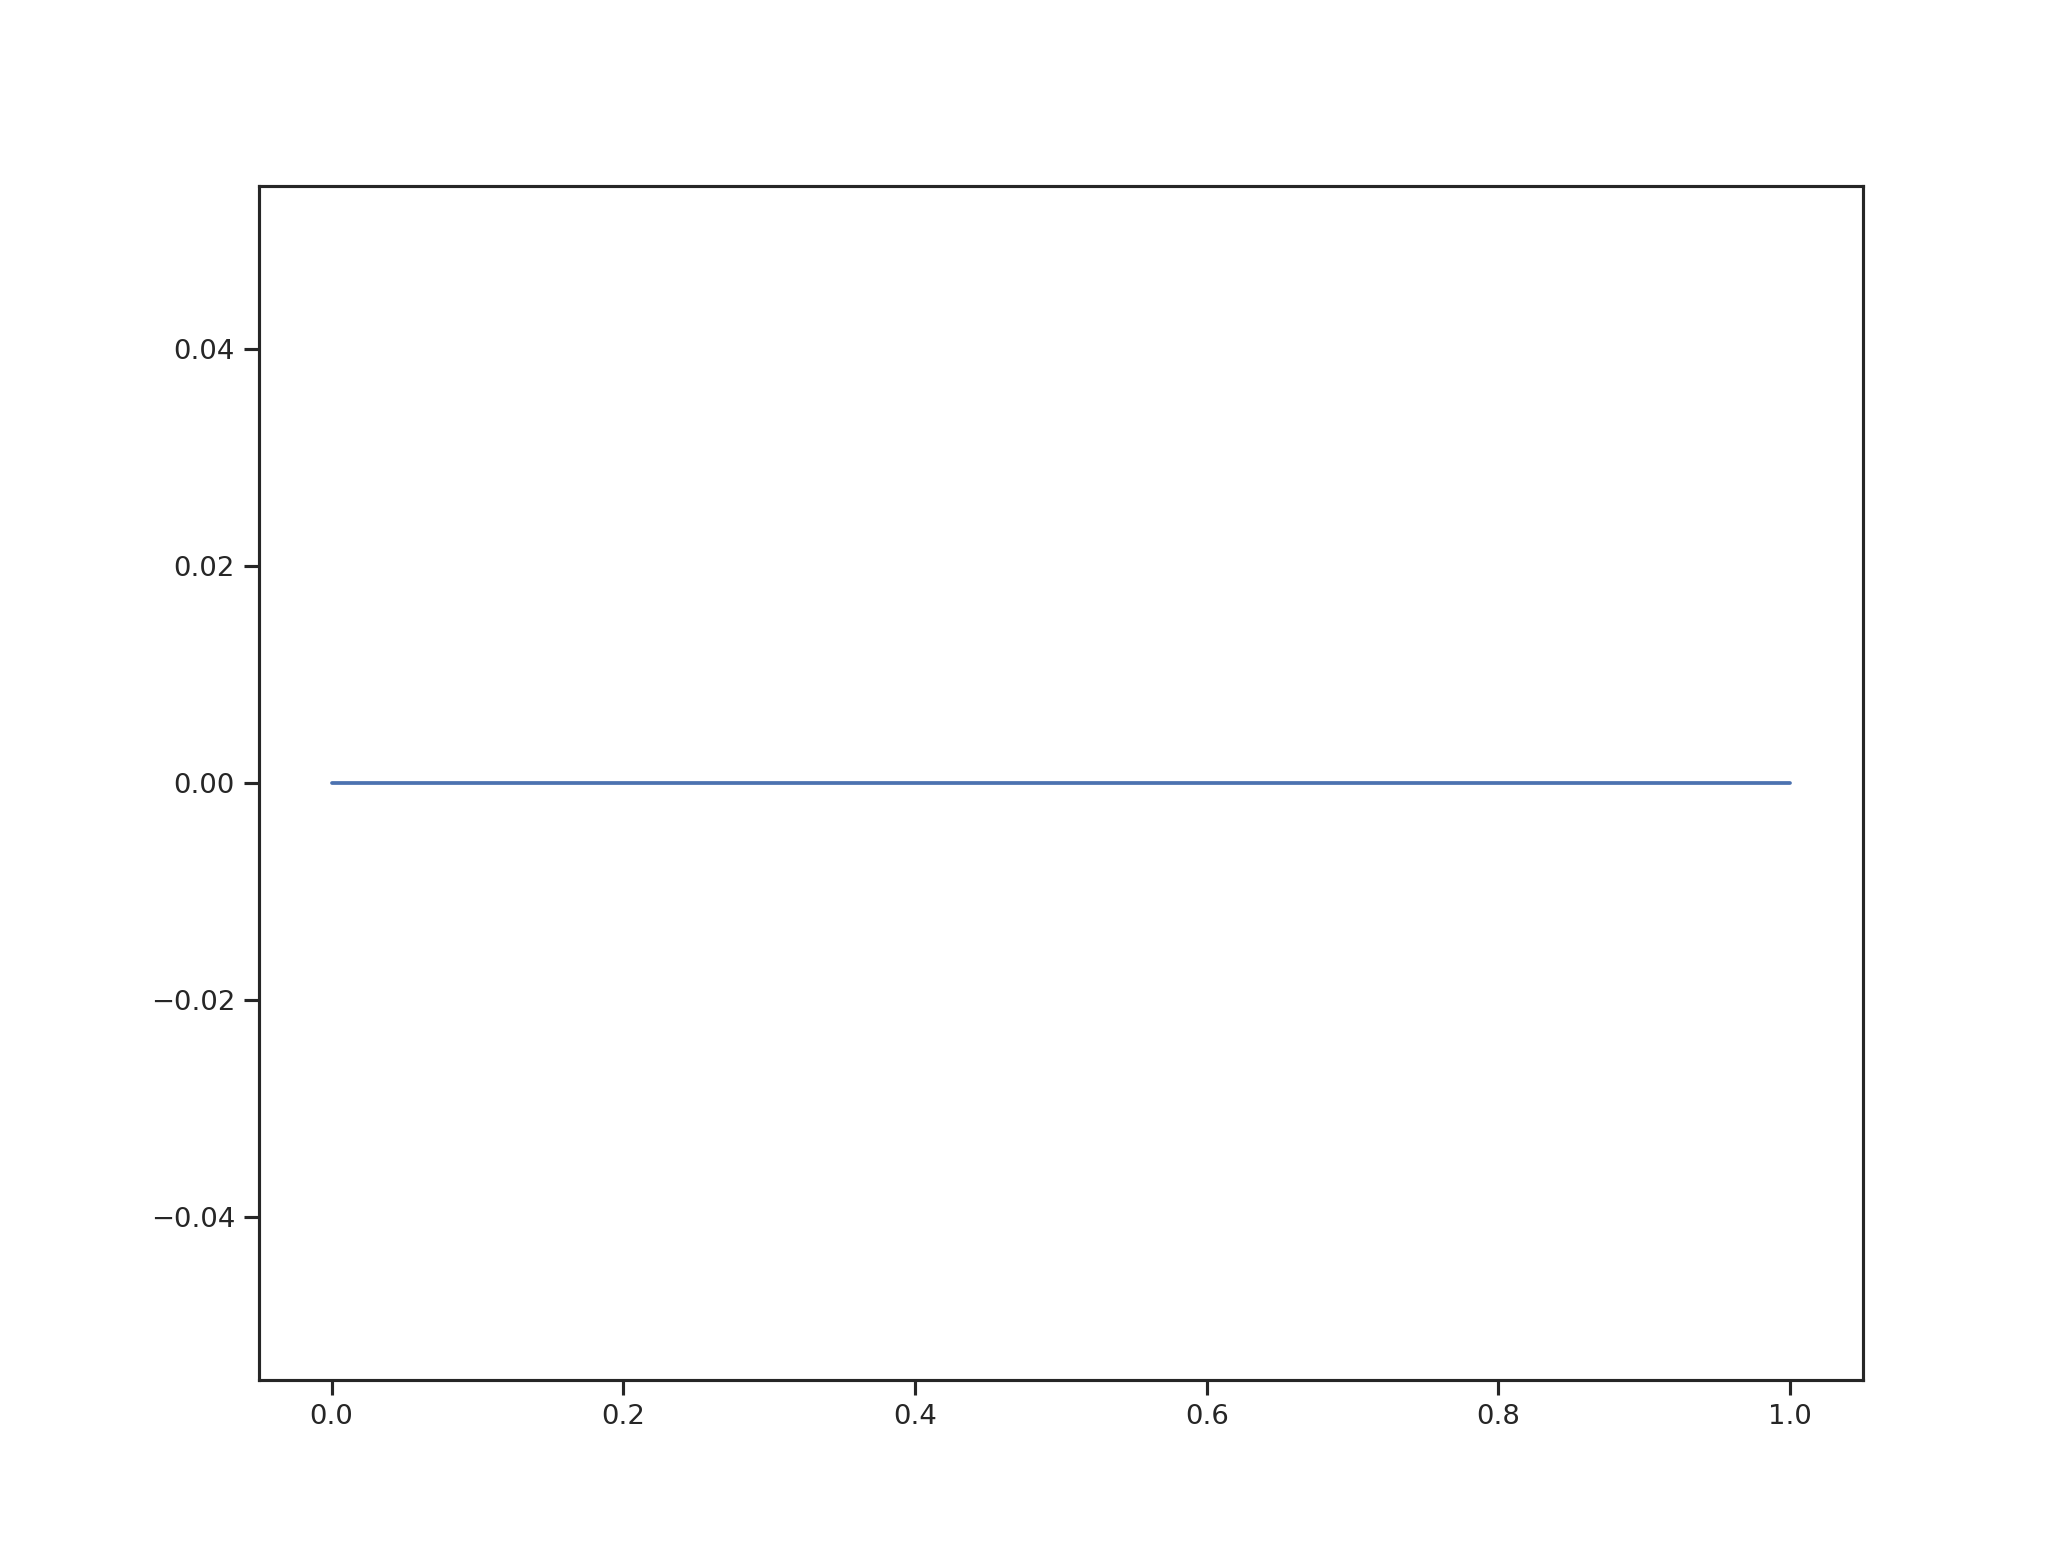

In [41]:
dataset.plot_all()

We also make a t-SNE plot.

<IPython.core.display.Javascript object>


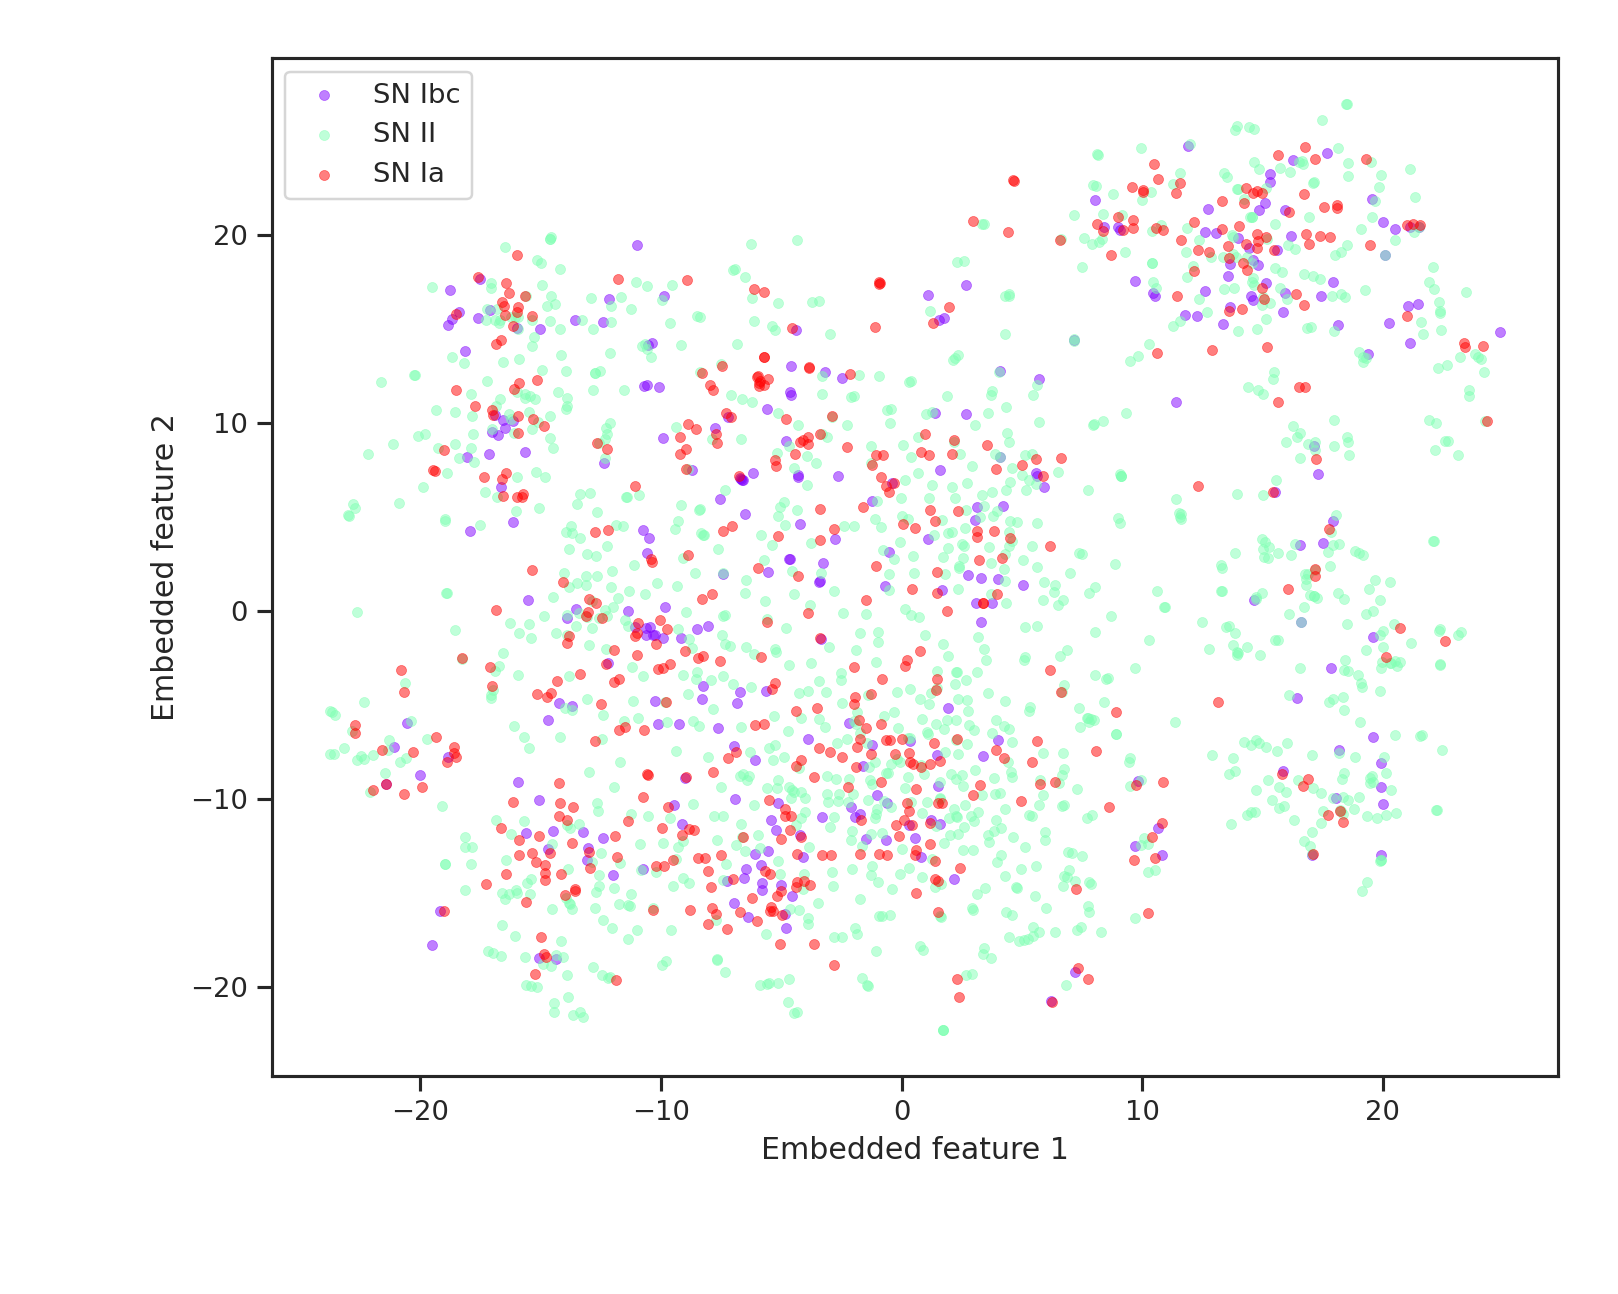

In [42]:
plt.figure(figsize=(5,4))
tsne_plot.plot(model2_features, types['Type'], type_dict={1:'SN Ia', 2:'SN II', 3: 'SN Ibc'})

### 3. Wavelet features

The wavelet feature extraction process is quite complicated, although it is fairly fast. Remember to save the PCA eigenvalues, vectors and mean for later reconstruction!

In [43]:
wavelet_features_instance = snfeatures.WaveletFeatures(output_root=path_saved_interm)

In [44]:
%%capture --no-stdout
if read_from_file:
    wavelet_features = Table.read(f'{run_name}_wavelets.dat', format='ascii')
    #Crucial for this format of id's
    better_name = wavelet_features['Object'].astype(str)
    wavelet_features.replace_column('Object', better_name)
    pca_vals = np.loadtxt(f'{run_name}_wavelets_PCA_vals.dat')
    pca_vec = np.loadtxt(f'{run_name}_wavelets_PCA_vec.dat')
    pca_mean = np.loadtxt(f'{run_name}_wavelets_PCA_mean.dat')
else:
    wavelet_features_pd = wavelet_features_instance.extract_features(
        dataset, number_gp=100, t_min=0, t_max=dataset.get_max_length(),
        number_processes=1, gp_dim=1, number_comps=20,
        output_root=path_saved_interm)
    
    # Change to astropy table
    wavelet_features = Table(wavelet_features_pd.to_numpy())
    column_names = wavelet_features.colnames
    column_names.insert(0, 'Object')
    objs_name = list(wavelet_features_pd.index)
    wavelet_features.add_column(objs_name, name='Object')
    wavelet_features = wavelet_features[column_names]
    wavelet_features.write(f'{run_name}_wavelets.dat', format='ascii')
    
    # Load from where they were saved
    pca_vals = np.load(os.path.join(path_saved_interm,
                                    'eigenvalues.npy'))
    pca_vec = np.load(os.path.join(path_saved_interm,
                                   'eigenvectors.npy'))
    pca_mean = np.load(os.path.join(path_saved_interm, 'means.npy'))
    
    # Save in a different way
    np.savetxt(f'{run_name}_wavelets_PCA_vals.dat', pca_vals)
    np.savetxt(f'{run_name}_wavelets_PCA_vec.dat', pca_vec)
    np.savetxt(f'{run_name}_wavelets_PCA_mean.dat', pca_mean)

Extracting features of the dataset.
Performing Gaussian process regression.
Models fitted with the Gaussian Processes values.
Time taken for Gaussian process regression: 285.78s.
The wavelet used is sym2.
Each passband is decomposed in 2 levels.
Performing wavelet decomposition.
Time taken for wavelet decomposition: 13.28s.
Performing eigendecomposition.
Time taken for eigendecomposition: 4.27s.
Dimensionality reduced feature space with 20 components.
Time taken to extract features: 306.17s.


Finally, we take the features and generate the model light curve for plotting purposes.

In [45]:
# Transform the astropy tables into pandas
wavelet_features_pd = wavelet_features.to_pandas()
wavelet_features_pd.set_index('Object', inplace=True)

In [46]:
dataset.set_model(wavelet_features_instance.fit_sn,
                  wavelet_features_pd, dataset, 'sym2', 
                  path_saved_interm, dataset.filter_set)

Fitting transient models...
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is deco

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wave

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensio

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensio

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensio

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wave

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensio

Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensio

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wave

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each passband is decomposed in 2 levels.
The wavelet used is sym2.
Dimensionality reduced feature space with 20 components.
Each pas

Now we can see how well the SALT2 model fits our light curves.

<IPython.core.display.Javascript object>


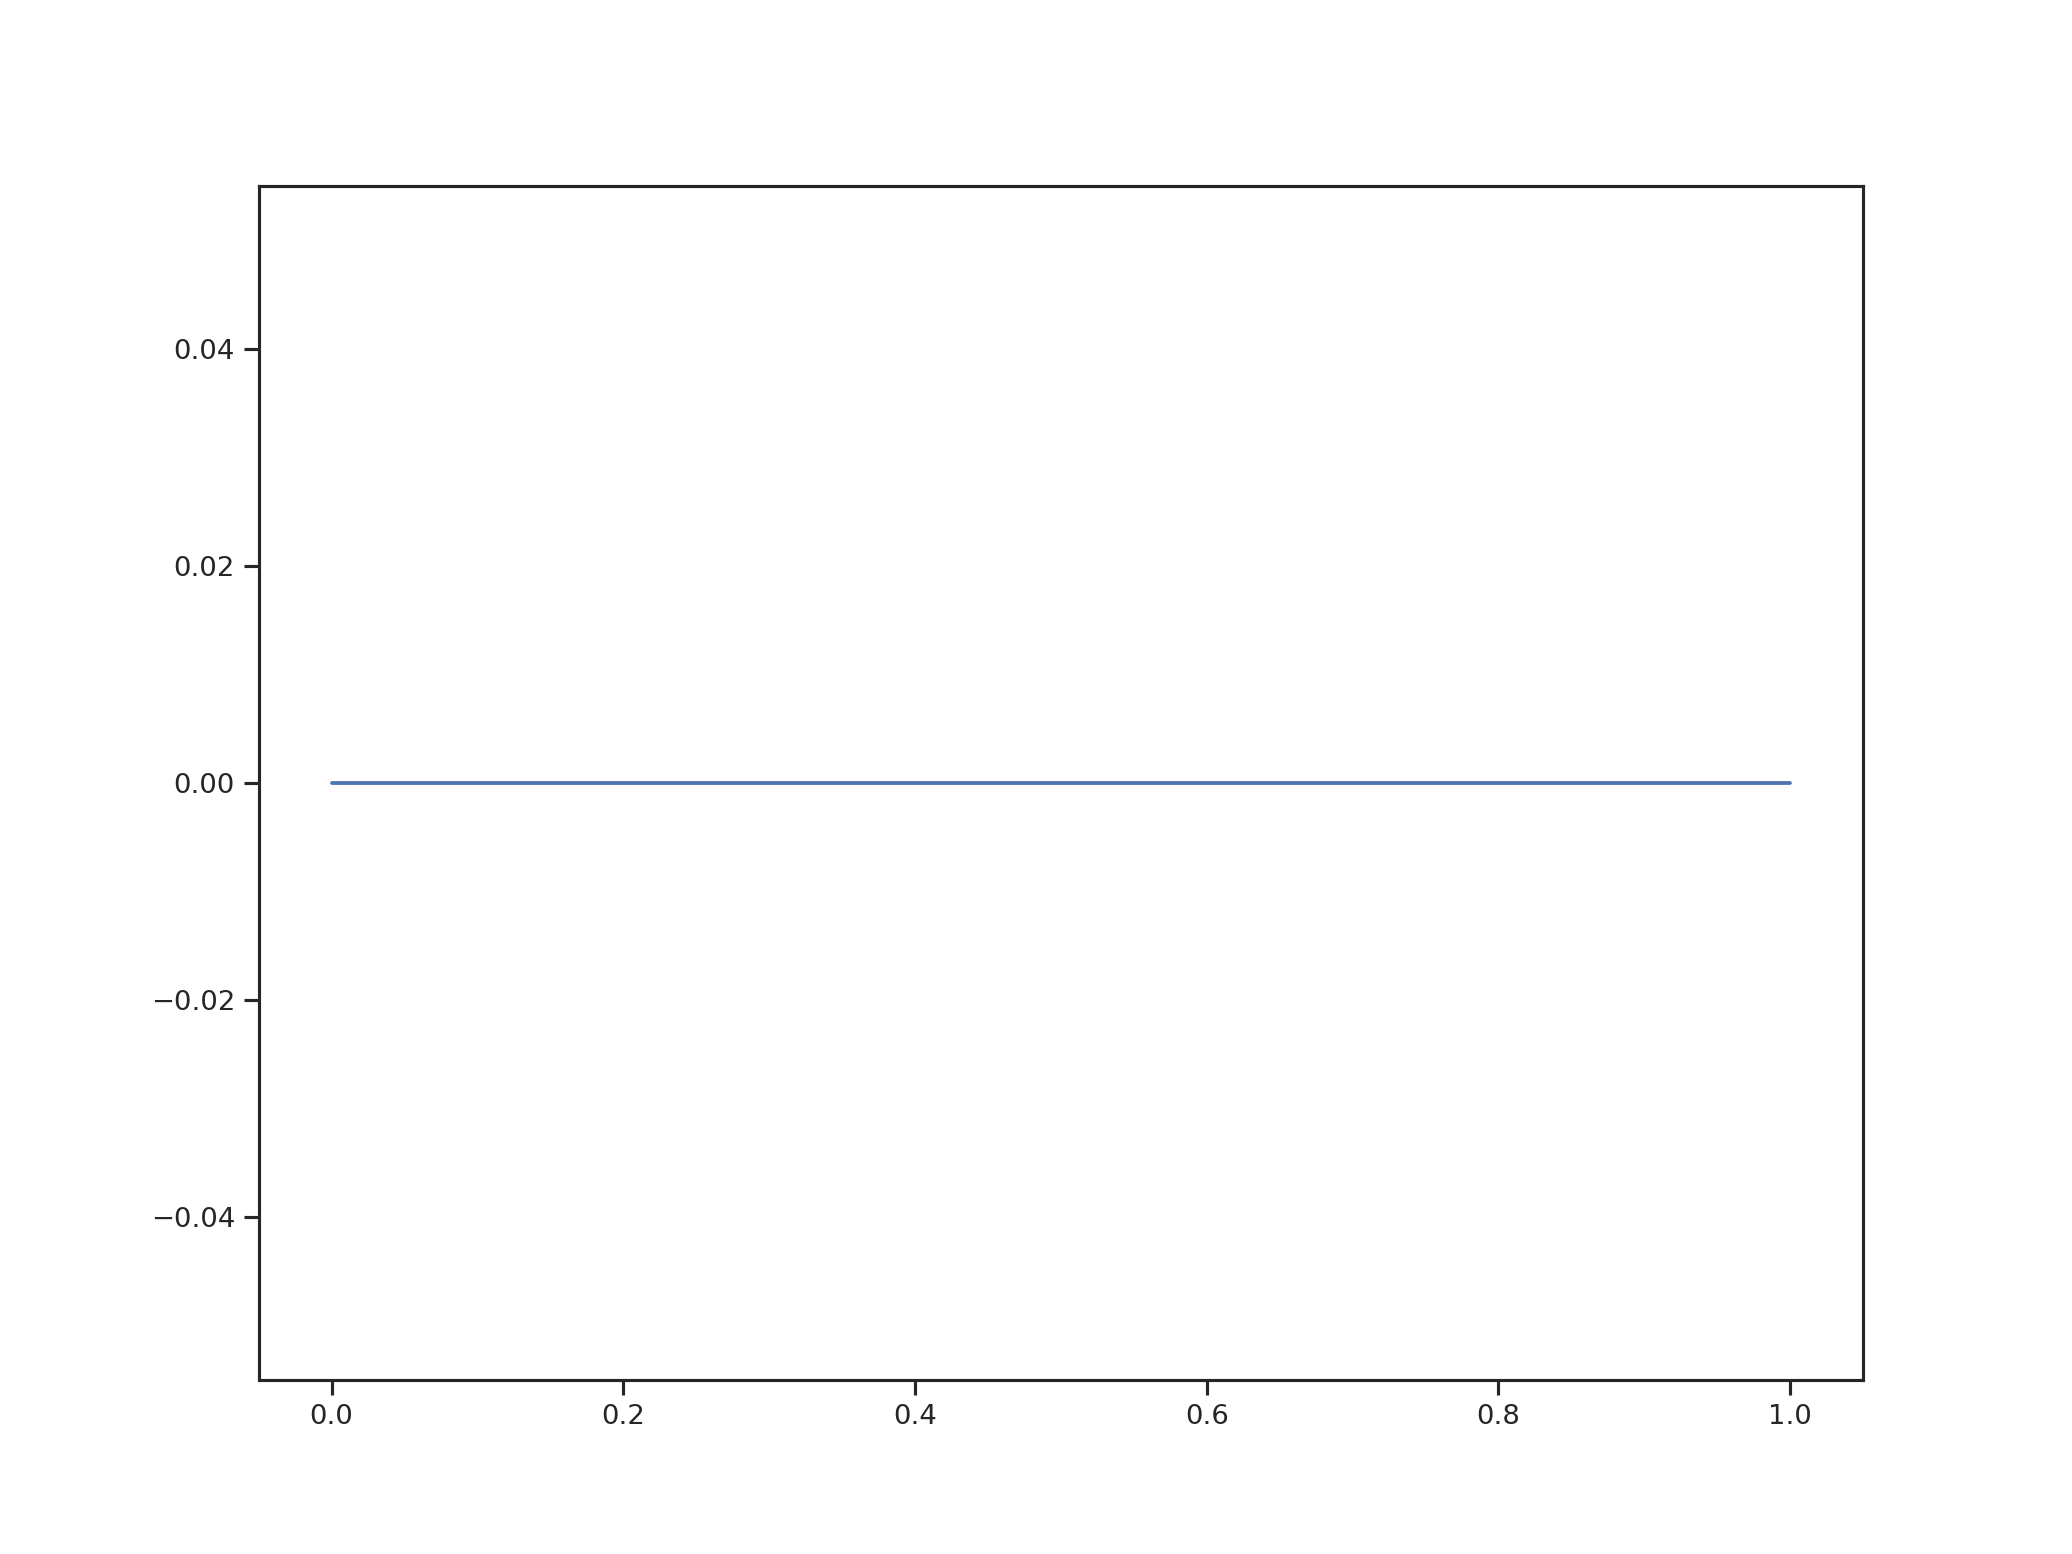

In [47]:
dataset.plot_all()

We also make a t-SNE plot.

<IPython.core.display.Javascript object>


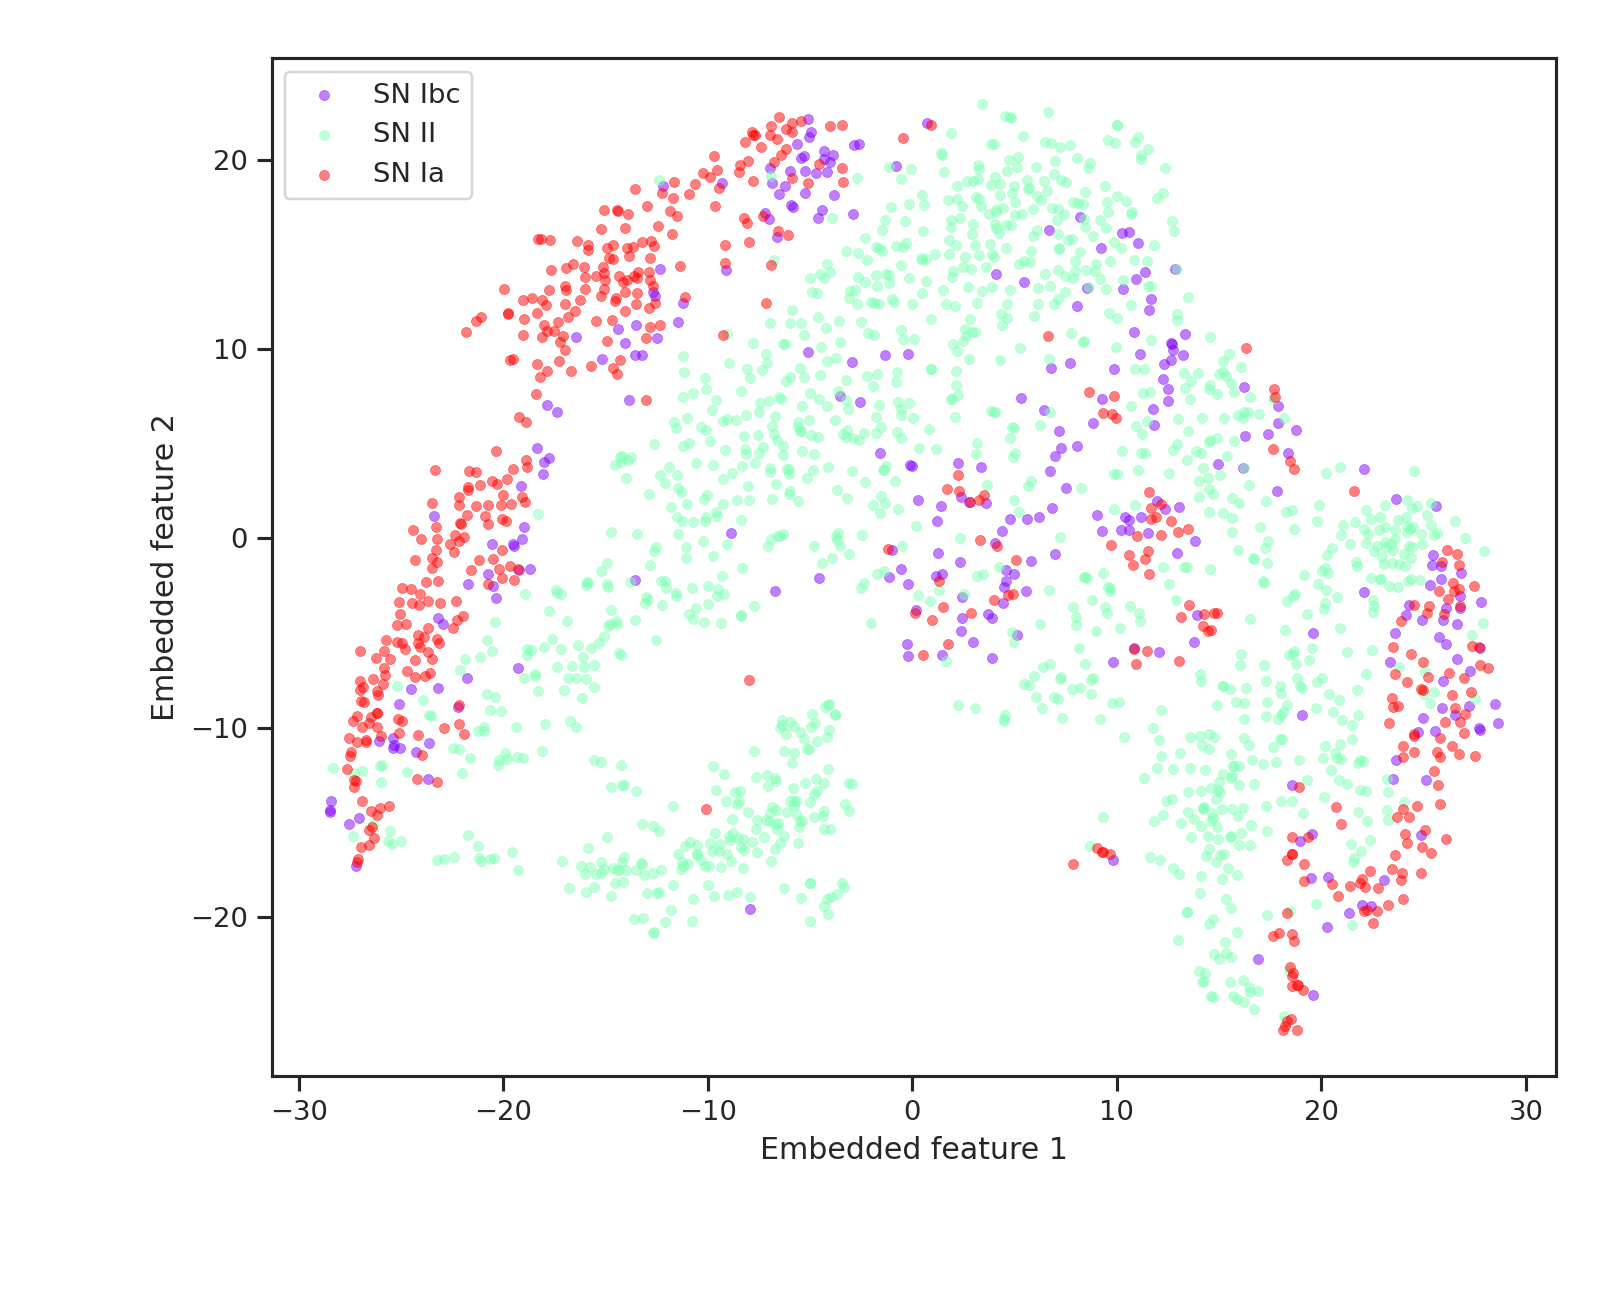

In [48]:
plt.figure(figsize=(5,4))
tsne_plot.plot(wavelet_features, types['Type'], type_dict={1:'SN Ia', 2:'SN II', 3: 'SN Ibc'})

## Classify

Finally, we're ready to run the machine learning algorithm. There's a utility function in the `snclassifier` library to make it easy to run all the algorithms available, including converting features to `numpy` arrays and rescaling them and automatically generating ROC curves and metrics. Hyperparameters are automatically selected using a grid search combined with cross-validation. All functionality can also be individually run from `snclassifier`.

Classifiers can be run in parallel, change `number_processes` to the number of processors on your machine (we're only running 4 algorithms so it won't help to set this any higher than 4).

In [49]:
number_processes = 4

In [50]:
print('The available classifiers are:', snclassifier.choice_of_classifiers)

The available classifiers are: ['svm', 'knn', 'random_forest', 'decision_tree', 'boost_dt', 'boost_rf', 'nb', 'neural_network', 'lgbm']


In [51]:
which_column = 0  # SN Ia is the first column

### 1. SALT2 Template features

In [52]:
# Transform the astropy tables into pandas
salt2_features_pd = salt2_features.to_pandas()
salt2_features_pd.set_index('Object', inplace=True)
data_labels = types.to_pandas()
data_labels.set_index('Object', inplace=True)
data_labels = data_labels['Type']

<IPython.core.display.Javascript object>


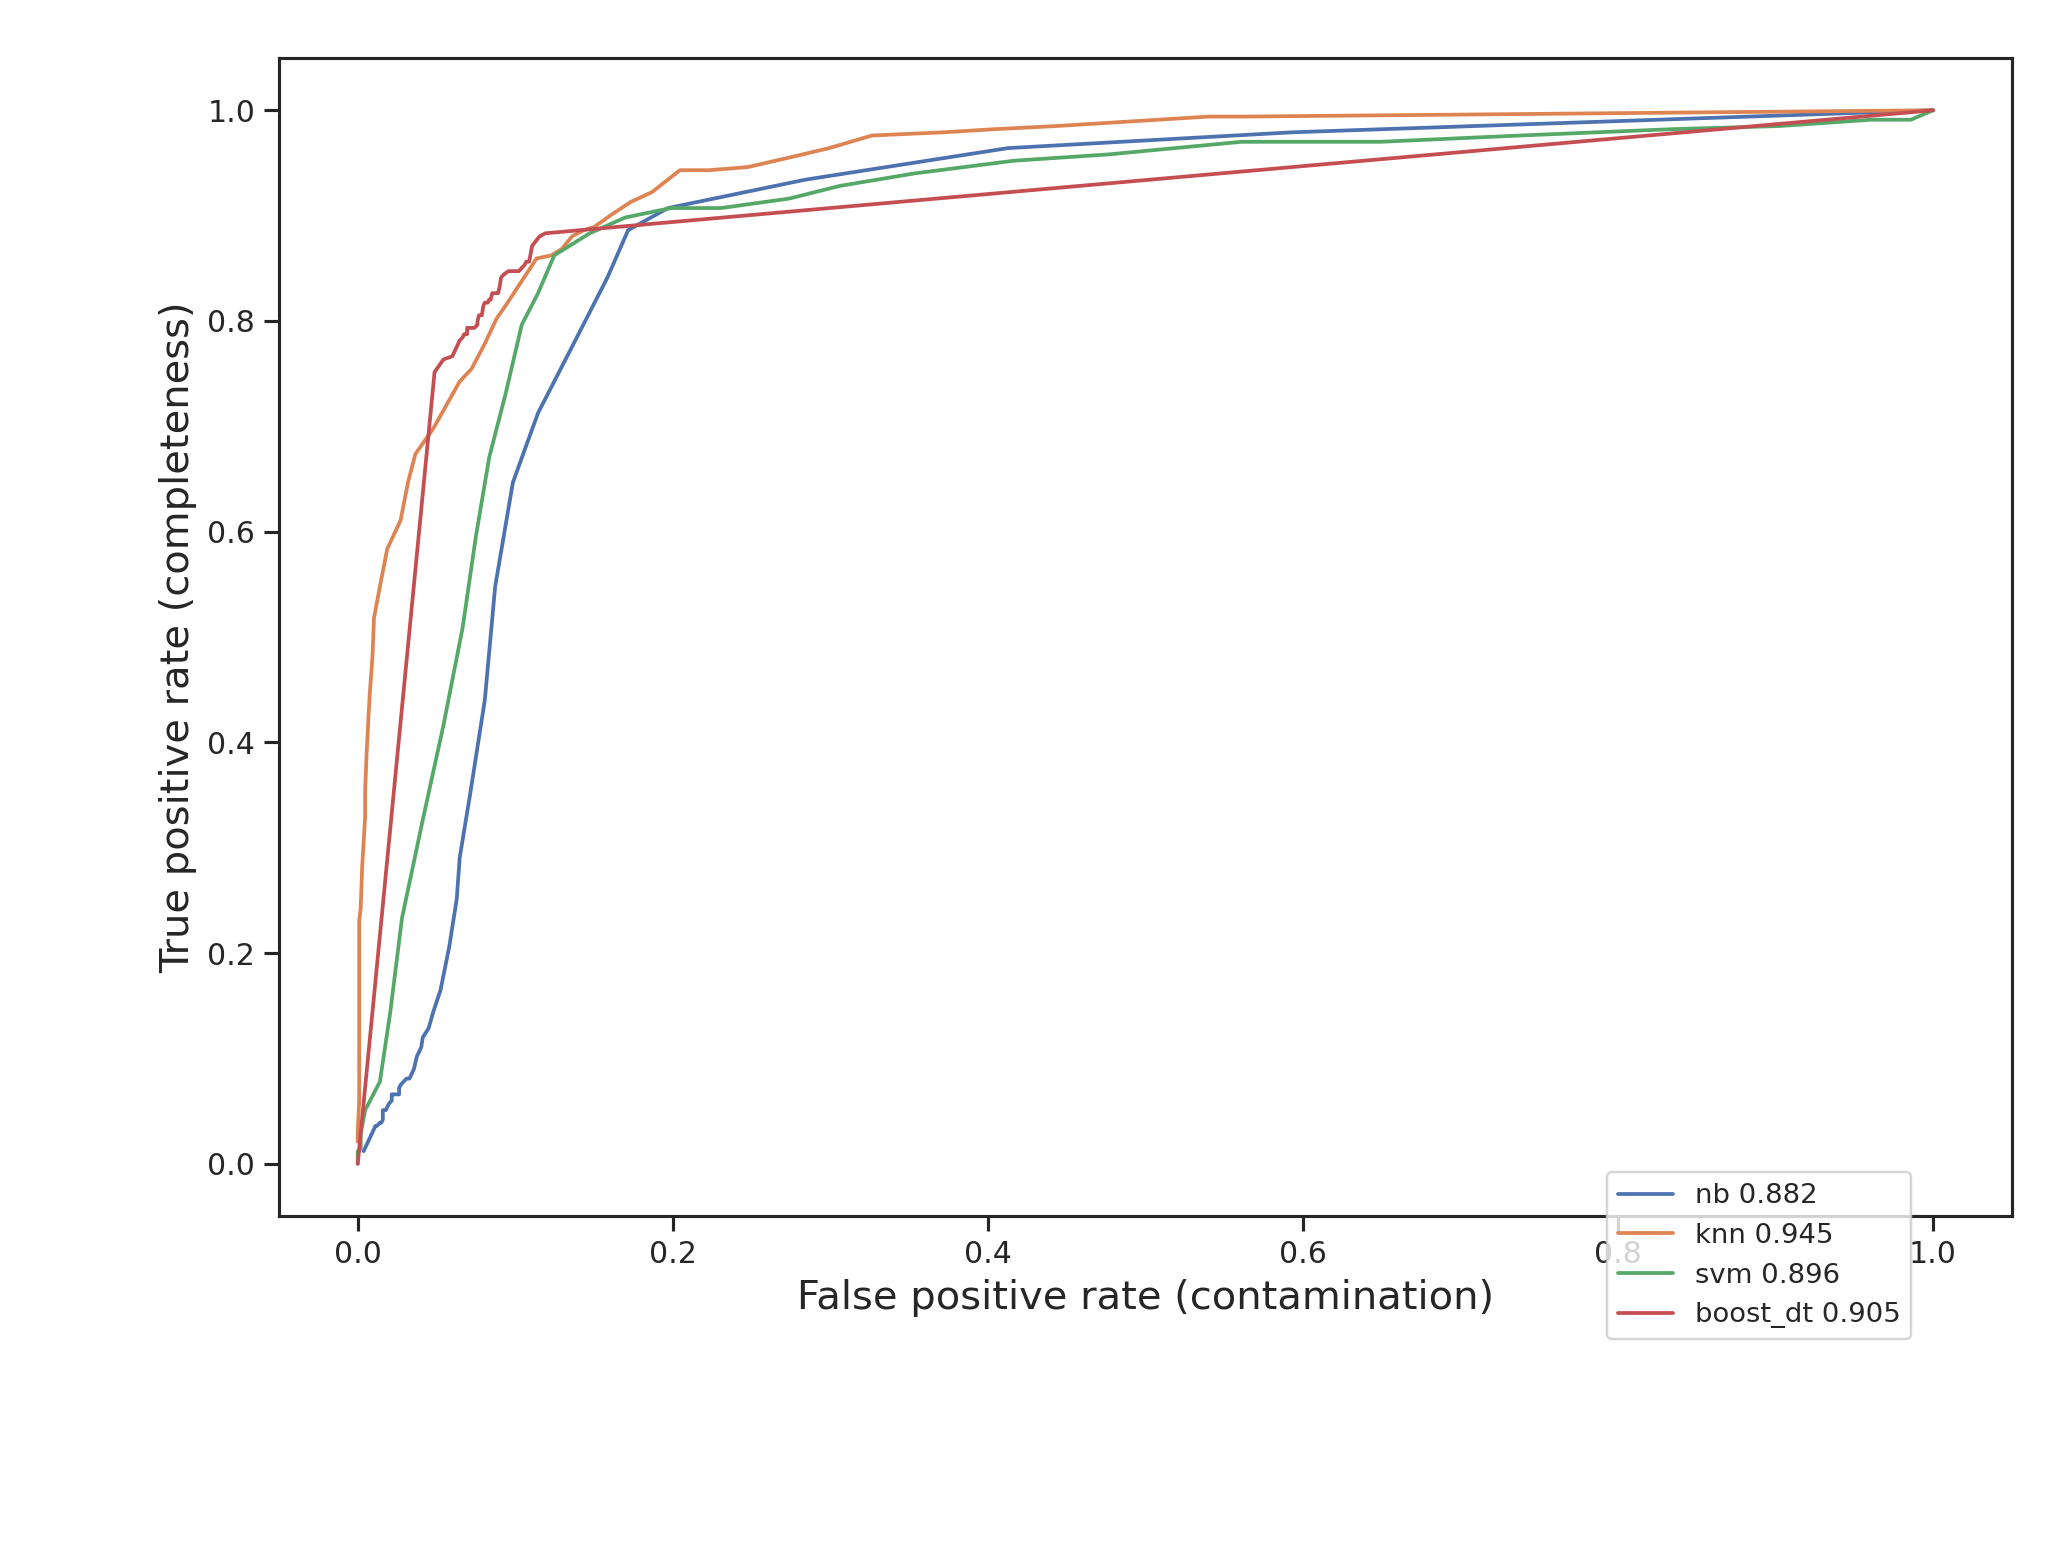

Created classifier of type: AdaBoostClassifier(random_state=RandomState(MT19937) at 0x7F992E7536B0).
Created classifier of type: SVC(probability=True, random_state=RandomState(MT19937) at 0x7F992E7536B0).
Created classifier of type: KNeighborsClassifier(weights='distance').
Created classifier of type: GaussianNB().



Using the default parameter grid optimisation.Using the default parameter grid optimisation.Using the default parameter grid optimisation.



This class has no default hyperparameter range.
Using the default parameter grid optimisation.
The optimisation takes 0.074s.
The optimisation takes 2.884s.
The optimisation takes 29.423s.
The optimisation takes 52.004s.
Classifier nb: AUC = 0.8815890732606082 ; FoM = 0.30888748818153167.
Probabilities, AUC and ROC saved on ./output_spcc_no_z/classifications.
Classifier knn: AUC = 0.9451795283728979 ; FoM = 0.4612728032307478.
Probabilities, AUC and ROC saved on ./output_spcc_no_z/classifications.
Classifier svm: AUC = 0.89567441102

In [53]:
plt.figure()
classifier_instances, cms = snclassifier.run_several_classifiers(
    classifier_list=['nb', 'knn', 'svm', 'boost_dt'], 
    features=salt2_features_pd, labels=data_labels,  scoring='accuracy', 
    train_set=.3, scale_features=True, which_column=which_column, 
    random_seed=42, output_root=path_saved_classifier,
    **{'plot_roc_curve': True, 'number_processes': number_processes})

### 2.1 Parametric fits - model 1 (Newling et al.)

In [54]:
# Transform the astropy tables into pandas
model1_features_pd = model1_features.to_pandas()
model1_features_pd.set_index('Object', inplace=True)

<IPython.core.display.Javascript object>


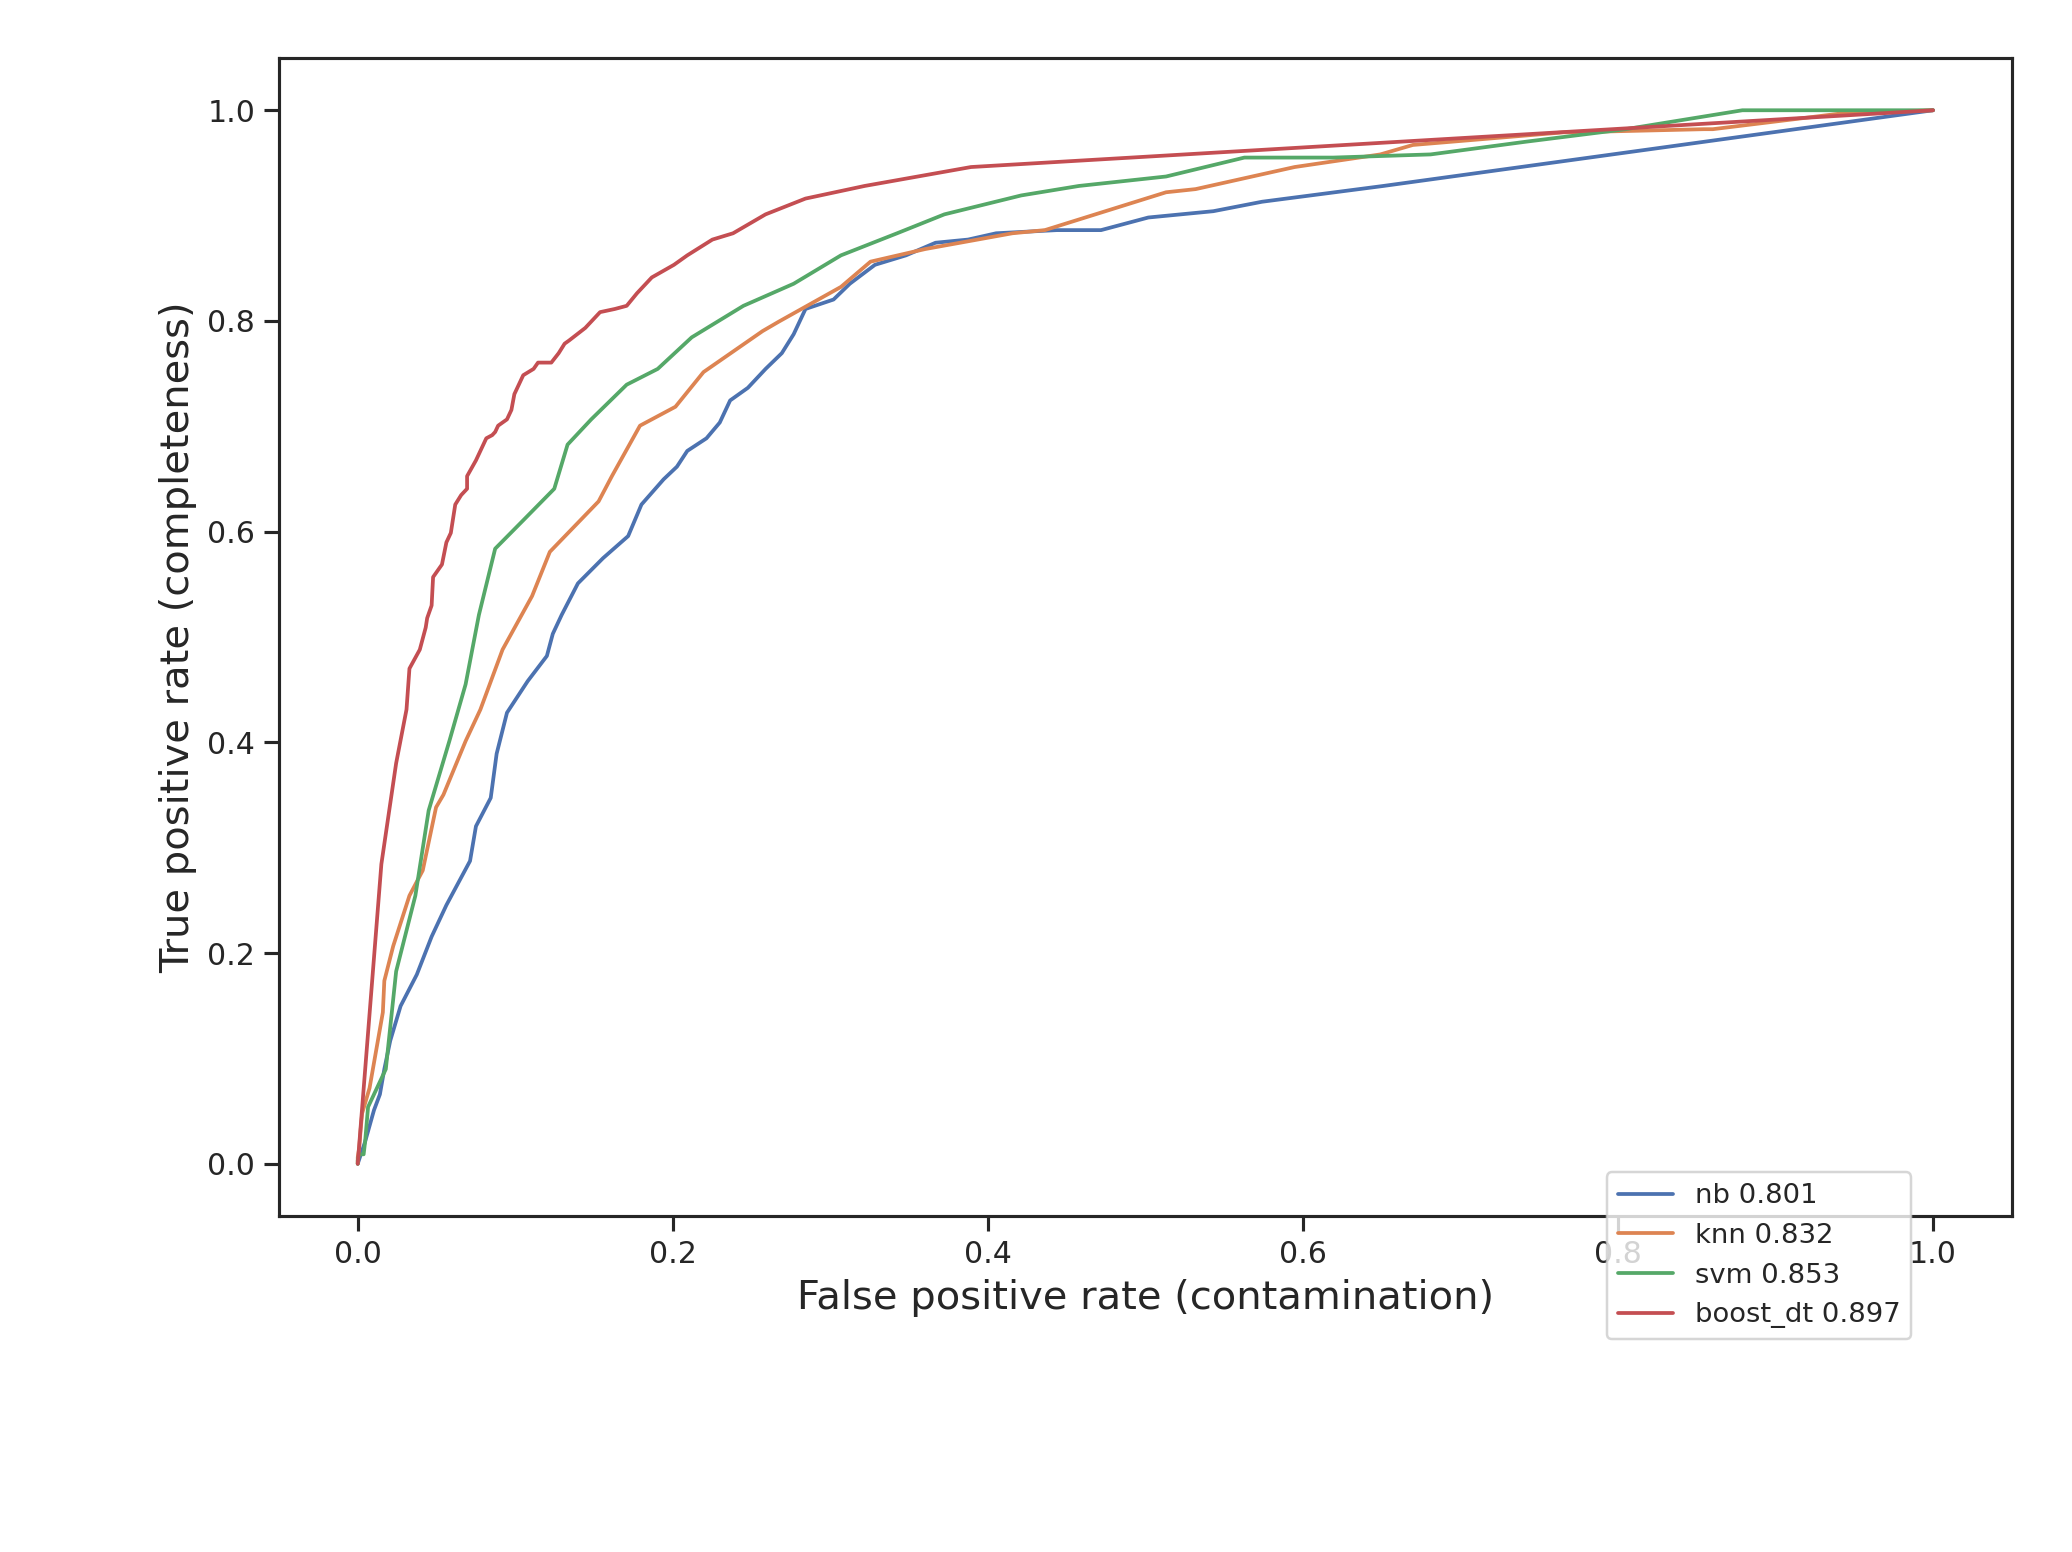

Created classifier of type: SVC(probability=True, random_state=RandomState(MT19937) at 0x7F992E753AF0).
Created classifier of type: KNeighborsClassifier(weights='distance').
Created classifier of type: GaussianNB().
Created classifier of type: AdaBoostClassifier(random_state=RandomState(MT19937) at 0x7F992E753AF0).




Using the default parameter grid optimisation.Using the default parameter grid optimisation.This class has no default hyperparameter range.Using the default parameter grid optimisation.



Using the default parameter grid optimisation.
The optimisation takes 0.071s.
The optimisation takes 2.540s.
The optimisation takes 32.249s.
The optimisation takes 116.270s.
Classifier nb: AUC = 0.8012282189841704 ; FoM = 0.1859505988023952.
Probabilities, AUC and ROC saved on ./output_spcc_no_z/classifications.
Classifier knn: AUC = 0.832158384918718 ; FoM = 0.20321525926709003.
Probabilities, AUC and ROC saved on ./output_spcc_no_z/classifications.
Classifier svm: AUC = 0.85299148419

In [55]:
plt.figure()
classifier_instances, cms = snclassifier.run_several_classifiers(
    classifier_list=['nb', 'knn', 'svm', 'boost_dt'], 
    features=model1_features_pd, labels=data_labels,  scoring='accuracy', 
    train_set=.3, scale_features=True, which_column=which_column, 
    random_seed=42, output_root=path_saved_classifier,
    **{'plot_roc_curve': True, 'number_processes': number_processes})

### 2.2 Parametric fits - model 2 (Karpenka et al.)

In [56]:
# Transform the astropy tables into pandas
model2_features_pd = model2_features.to_pandas()
model2_features_pd.set_index('Object', inplace=True)

<IPython.core.display.Javascript object>


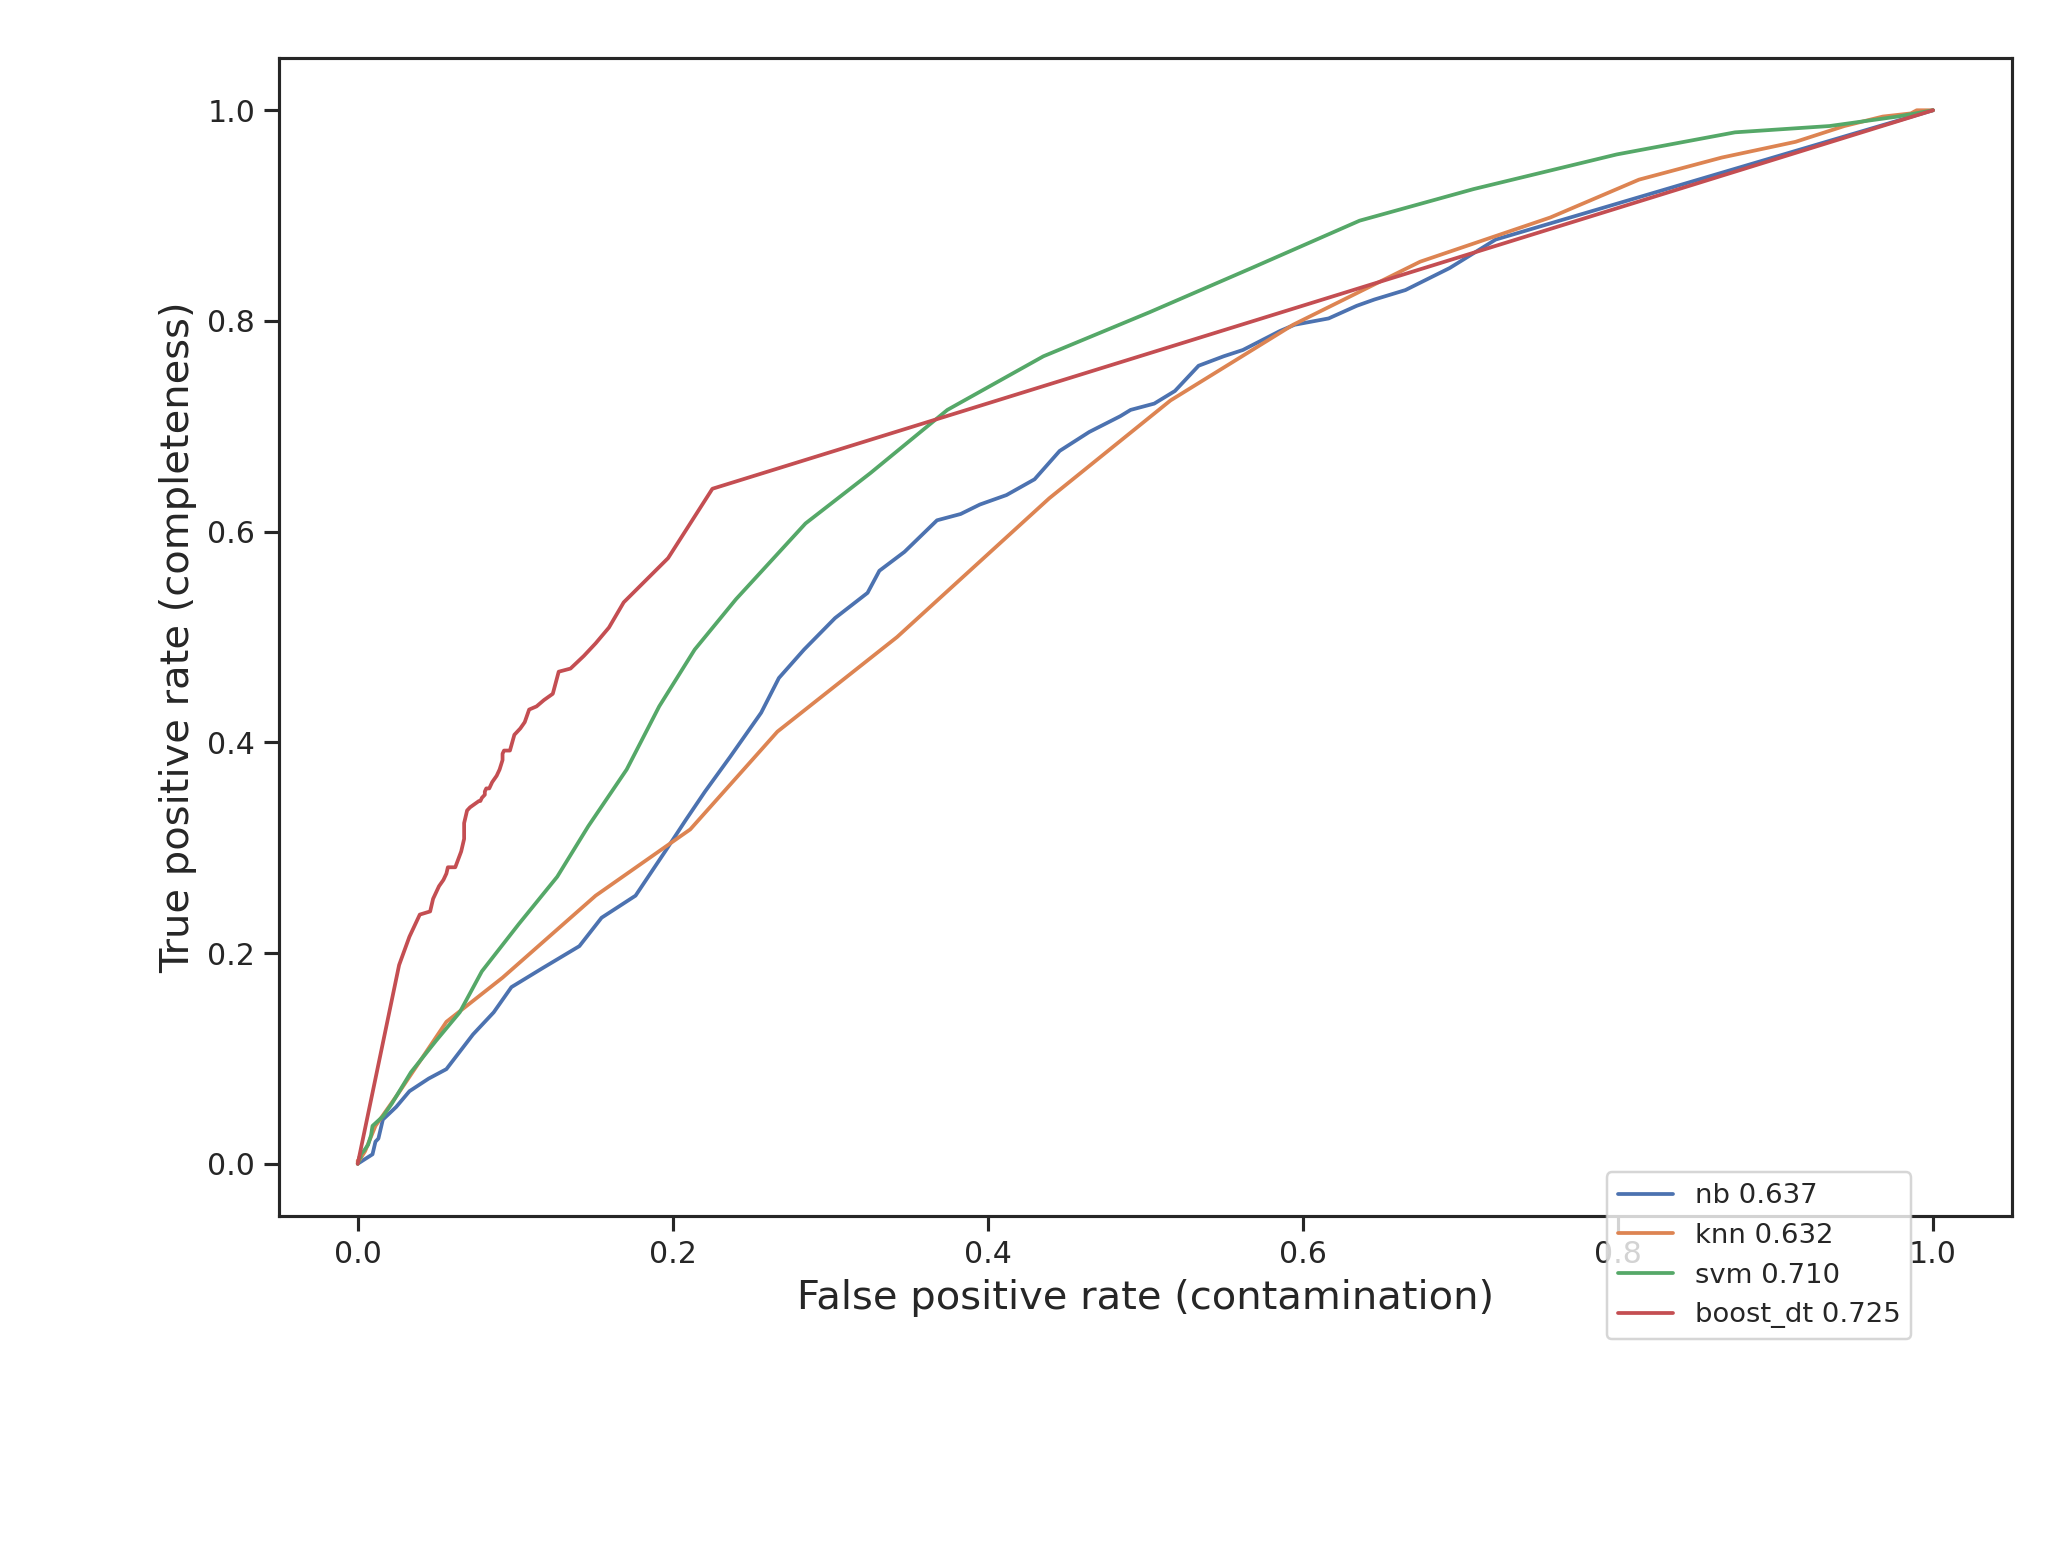

Created classifier of type: GaussianNB().
Created classifier of type: SVC(probability=True, random_state=RandomState(MT19937) at 0x7F992E753E20).
Created classifier of type: AdaBoostClassifier(random_state=RandomState(MT19937) at 0x7F992E753E20).
Created classifier of type: KNeighborsClassifier(weights='distance').




This class has no default hyperparameter range.Using the default parameter grid optimisation.Using the default parameter grid optimisation.Using the default parameter grid optimisation.



Using the default parameter grid optimisation.
The optimisation takes 0.091s.
The optimisation takes 2.510s.
The optimisation takes 41.534s.
The optimisation takes 138.164s.
Classifier nb: AUC = 0.6371909089887767 ; FoM = 0.09894544403786788.
Probabilities, AUC and ROC saved on ./output_spcc_no_z/classifications.
Classifier knn: AUC = 0.6318601071777645 ; FoM = 0.10062418176655501.
Probabilities, AUC and ROC saved on ./output_spcc_no_z/classifications.
Classifier svm: AUC = 0.709600498

In [57]:
plt.figure()
classifier_instances, cms = snclassifier.run_several_classifiers(
    classifier_list=['nb', 'knn', 'svm', 'boost_dt'], 
    features=model2_features_pd, labels=data_labels,  scoring='accuracy', 
    train_set=.3, scale_features=True, which_column=which_column, 
    random_seed=42, output_root=path_saved_classifier,
    **{'plot_roc_curve': True, 'number_processes': number_processes})

### 3. Wavelet features

<IPython.core.display.Javascript object>


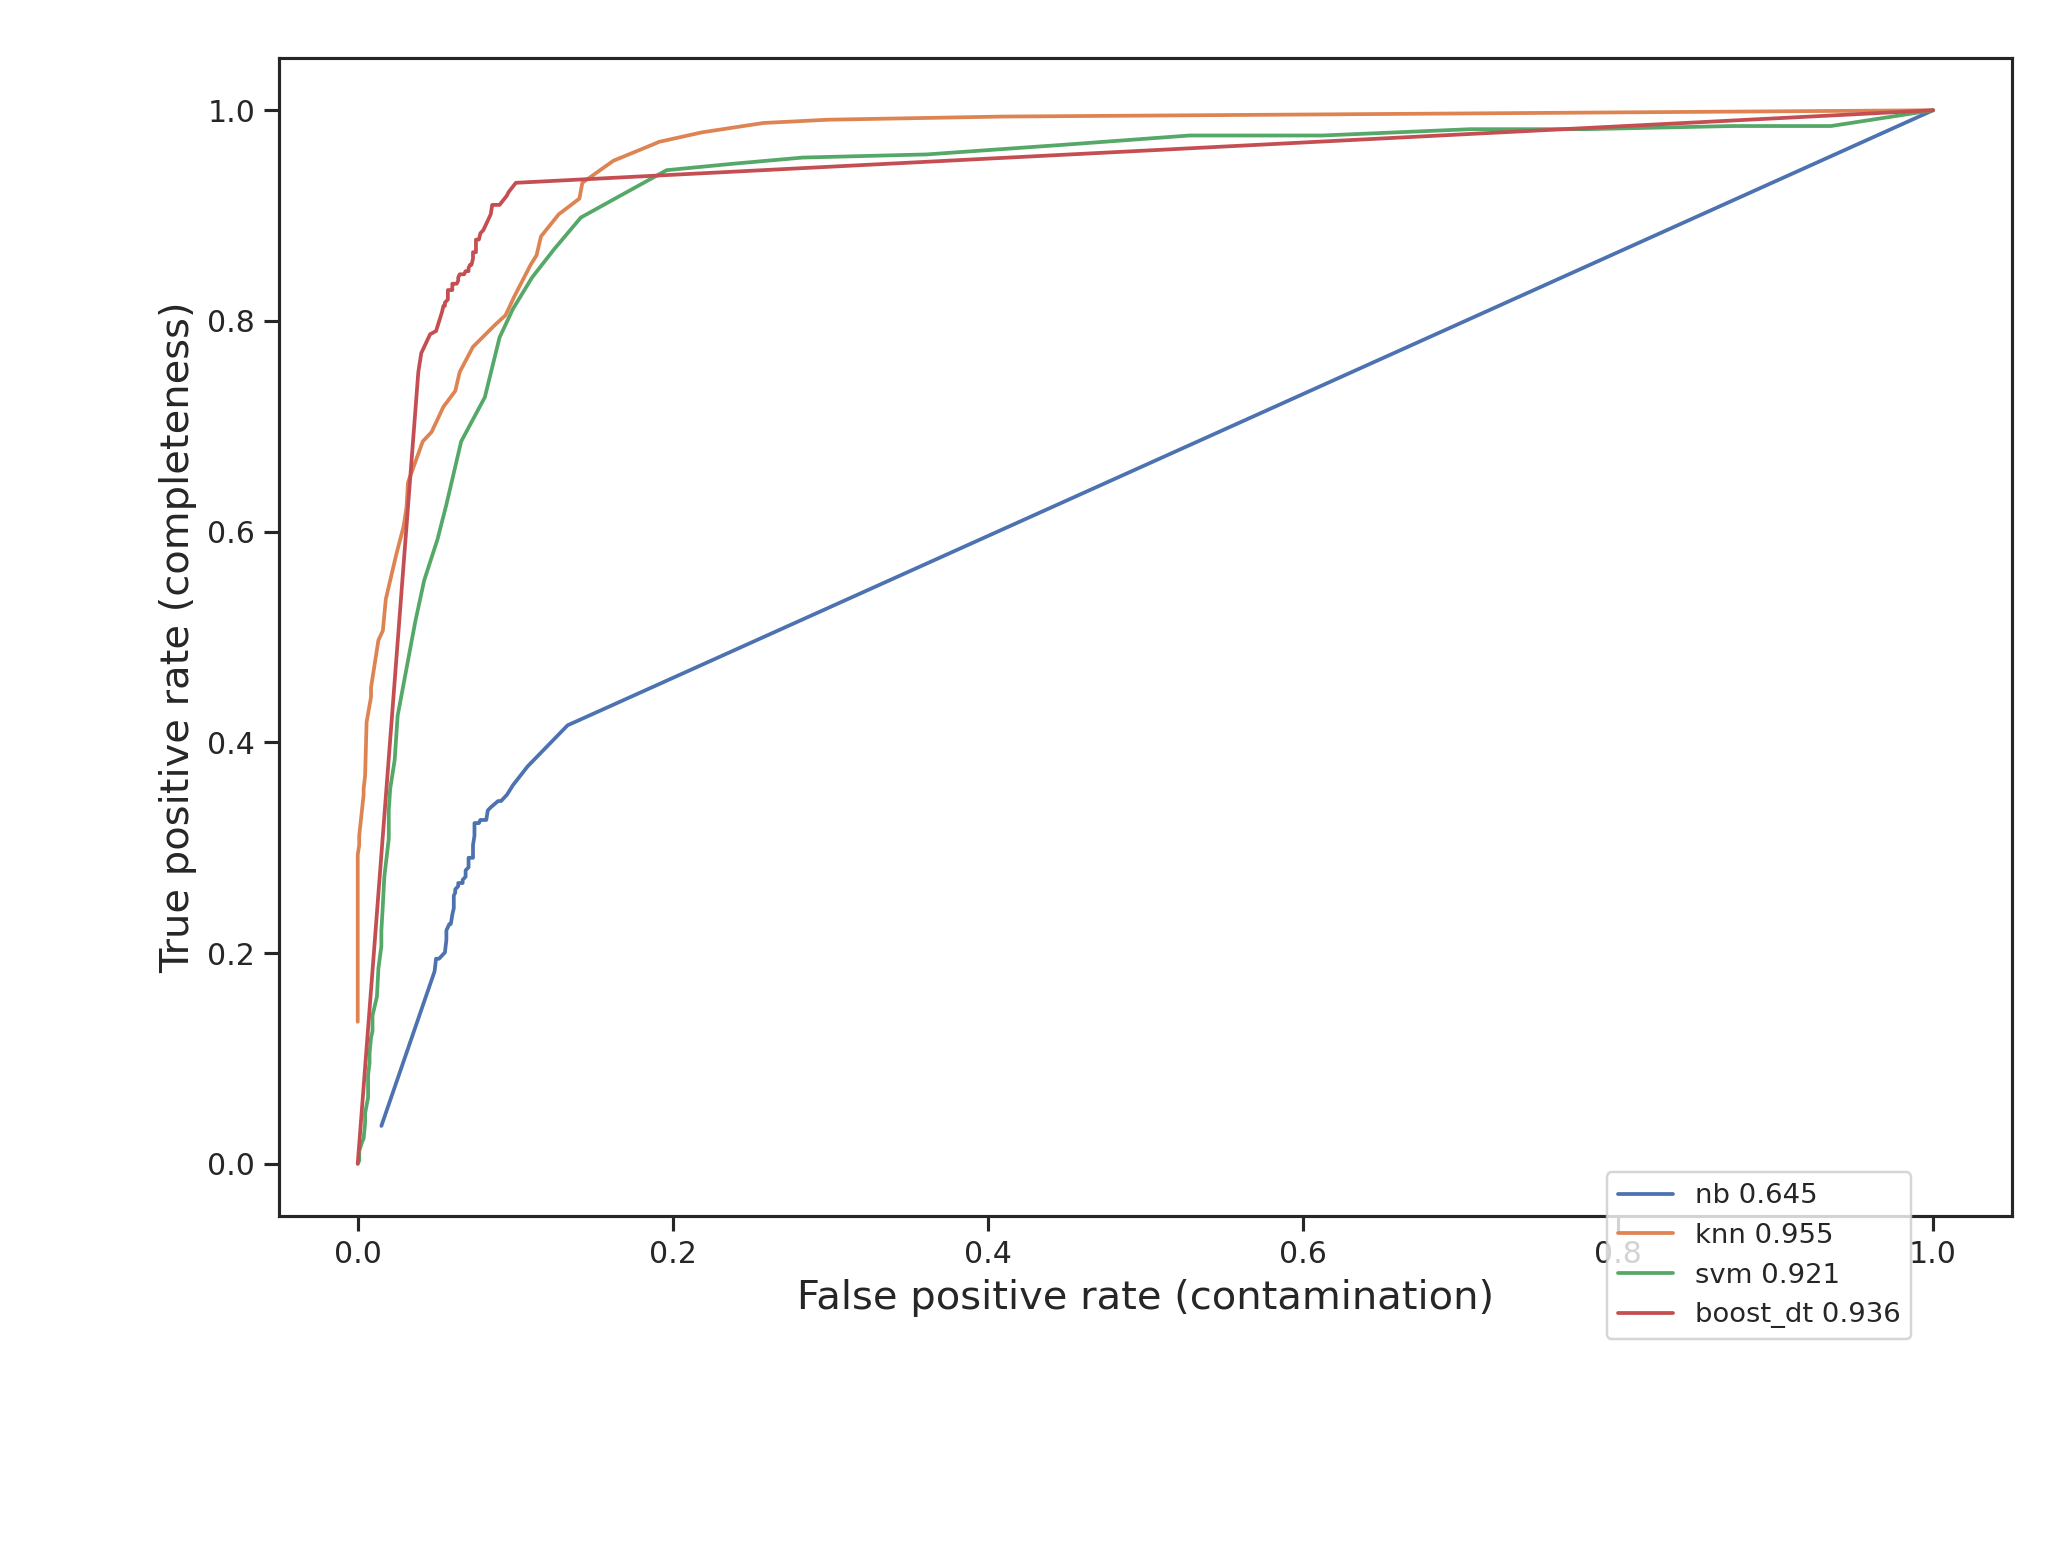

Created classifier of type: KNeighborsClassifier(weights='distance').
Created classifier of type: GaussianNB().
Created classifier of type: SVC(probability=True, random_state=RandomState(MT19937) at 0x7F992E753D10).



Created classifier of type: AdaBoostClassifier(random_state=RandomState(MT19937) at 0x7F992E753D10).
Using the default parameter grid optimisation.This class has no default hyperparameter range.
Using the default parameter grid optimisation.

Using the default parameter grid optimisation.
Using the default parameter grid optimisation.

The optimisation takes 0.072s.
The optimisation takes 2.512s.
The optimisation takes 27.656s.
The optimisation takes 113.127s.
Classifier nb: AUC = 0.64539214254418 ; FoM = 0.10736399541342846.
Probabilities, AUC and ROC saved on ./output_spcc_no_z/classifications.
Classifier knn: AUC = 0.9550266259226388 ; FoM = 0.43927239859902834.
Probabilities, AUC and ROC saved on ./output_spcc_no_z/classifications.
Classifier svm: AUC = 0.92147740166

In [58]:
plt.figure()
classifier_instances, cms = snclassifier.run_several_classifiers(
    classifier_list=['nb', 'knn', 'svm', 'boost_dt'], 
    features=wavelet_features_pd, labels=data_labels,  scoring='accuracy', 
    train_set=.3, scale_features=True, which_column=which_column, 
    random_seed=42, output_root=path_saved_classifier,
    **{'plot_roc_curve': True, 'number_processes': number_processes})

[Go back to top.](#index)